
# Cloud Coverage Detection
The role of clouds is essential in climate forecasting. Nevertheless, there is substantial uncertainty associated with predicting future cloud fractional cover, defined as the portion of the sky covered by clouds. This significant uncertainty complicates the task of making reliable climate projections.

### Our Task: 
> To build predictive models for cloud coverage prediction after the next 15, 25 and 30 minutes, given the data of past 360 minutes (6 hours).

### Our Approach: 
> In this notebook, we have implemented various multivariate time series forecasting models like Simple RNNs, LSTMs, GRUs, Custom Transformers and more, to predict the cloud cover percentage from the numerical data.
The training has been done on input sequences of 90 minutes (1.5 hours) and then prediction are taken for the next 15th, 25th and 30th minute.

### Final Results: 
> Weighted Metric = 0.5 x (metric for 15 mins) + 0.35 x (metric for 25 mins) + 0.15 x (metric for 30 mins)
> The metric here will be MSE, MAE and R2 score. We have also calculated the results for separate predictions.

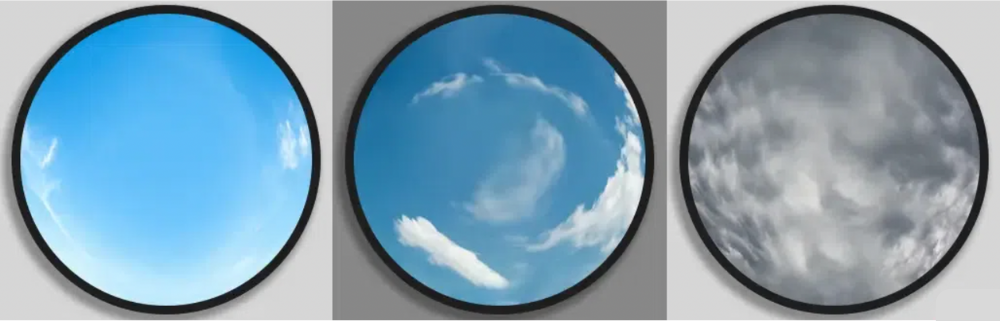
Increasing Cloud Cover Percentage (from left to right)

### **Each model implementation consists of the following parts:**

> 1) Loading Training and Validation Set
> 
> 2) Model Architecture/Definition
> 
> 3) Plot Model Layers/Blocks
> 
> 4) Model Training
> 
> 5) Scoring
> 
> 6) Visualization (Loss vs Epochs)

## Importing Packages

In [227]:
import warnings
warnings.filterwarnings('ignore')

import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, GRU, Dense, SimpleRNN, Dropout, Bidirectional
from tensorflow.keras.models import load_model

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from datetime import datetime

## Utility Functions

In [228]:
def load_dataframes(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val']

def plot_history(history, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Loading Train Data

In [229]:
train_df = pd.read_csv('/kaggle/input/train-csv/train.csv', low_memory=False)
test_df = pd.read_csv('/kaggle/input/test-ccd/testccd/CCD_test.csv', low_memory = False)

In [230]:
# Initial Data (without any processing)
train_df

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,01-Jan,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,01-Jan,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,01-Jan,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,01-Jan,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,01-Jan,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
test_df

,Unnamed: 0,scenario_set,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,0,0,1-Dec,7:50,54.3644,464.075,122.61168,-0.7910,-5.3070,-15.6070,27.230,3.0,0.95,243.70,810.312,0.0,0.080,0.0,0.4190
1,1,0,1-Dec,7:51,56.6827,472.765,122.77874,-0.6920,-5.1580,-15.6580,26.880,2.0,0.00,0.00,810.301,0.0,0.051,0.0,0.4066
2,2,0,1-Dec,7:52,57.8298,477.189,122.86244,-0.6315,-5.1465,-15.6465,26.775,2.0,0.00,0.00,810.295,0.0,0.034,0.0,0.3995
3,3,0,1-Dec,7:53,58.9769,481.613,122.94614,-0.5710,-5.1350,-15.6350,26.670,2.0,0.00,0.00,810.289,0.0,0.017,0.0,0.3924
4,4,0,1-Dec,7:54,61.2684,489.245,123.11386,-0.4860,-5.1240,-15.6240,26.510,2.0,0.00,0.00,810.307,0.0,-0.003,0.0,0.3778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55795,55795,154,Dec-31,14:25,358.4020,338.925,207.53615,5.9950,-0.0470,-8.9470,30.470,54.0,1.45,18.52,811.496,0.0,2.779,0.0,0.3348
55796,55796,154,Dec-31,14:26,375.2150,445.022,207.76500,5.9300,-0.1990,-9.4990,29.150,51.0,1.45,16.65,811.486,0.0,2.809,0.0,0.3322
55797,55797,154,Dec-31,14:27,422.8910,645.908,207.99338,5.8570,-0.2990,-9.5990,29.040,48.0,1.20,12.84,811.481,0.0,2.825,0.0,0.3428
55798,55798,154,Dec-31,14:28,476.0710,831.800,208.22132,5.8090,-0.1460,-8.9460,30.870,47.0,1.20,11.94,811.462,0.0,2.826,0.0,0.3337


# Preprocessing the Data

In [232]:
# Drop the NULL rows in the end 'all' drops the rows with all 
# columns NULL and 'any' drops the rows with any column with NULL values

train_df = train_df.dropna(how = 'all')

In [233]:
def normalize_date(date_str):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Check for 'Month-Day' format like Jan-1
    for month in months:
        if date_str.startswith(month):
            try:
                date_obj = datetime.strptime(date_str, '%b-%d')
                return date_obj.strftime('%m/%d/2024')
            except ValueError:
                return 'Invalid Date'
    
    # Check for 'Day-Month' format like 1-Jan
    for month in months:
        if date_str.endswith(month):
            try:
                date_obj = datetime.strptime(date_str, '%d-%b')
                return date_obj.strftime('%m/%d/2024')
            except ValueError:
                return 'Invalid Date'
    
    return 'Invalid Format'

train_df['DATE (MM/DD)'] = train_df['DATE (MM/DD)'].apply(normalize_date)
test_df['DATE (MM/DD)'] = test_df['DATE (MM/DD)'].apply(normalize_date)

In [234]:
# It's a leap year so adjusting 29-Feb manually as the above function doesn't adjust it

condition = train_df['DATE (MM/DD)'] == 'Invalid Date'
train_df.loc[condition, 'DATE (MM/DD)'] = '02/29/2024'

In [235]:
train_df['DATE (MM/DD)'] = pd.to_datetime(train_df['DATE (MM/DD)'], format='%m/%d/%Y')
test_df['DATE (MM/DD)'] = pd.to_datetime(test_df['DATE (MM/DD)'], format = '%m/%d/%Y')
print(train_df['DATE (MM/DD)'].dtype)

datetime64[ns]


In [236]:
train_df['MST'] = train_df['MST'] + ':00'
test_df['MST'] = test_df['MST'] + ':00'
print(train_df['MST'].dtype, test_df['MST'].dtype)

object object


In [237]:
train_df['MST'] = pd.to_datetime(train_df['MST'], format='%H:%M:%S').dt.time
test_df['MST'] = pd.to_datetime(test_df['MST'], format='%H:%M:%S').dt.time

print(train_df['MST'].dtype)

object


In [238]:
# Interpolating data: The process of estimating unknown values that 
# fall within the range of known data points.

train_df = train_df.sort_values(by=['DATE (MM/DD)', 'MST']).interpolate()
test_df = test_df.sort_values(by = ['scenario_set', 'DATE (MM/DD)', 'MST']).interpolate()

## Feature Engineering

In [239]:
# THI --> Temperature-Humidity Index

train_df['THI'] = train_df['Tower Dry Bulb Temp [deg C]'] + 0.36 * (train_df['Tower Dew Point Temp [deg C]'] - 14.4)
P0 = 1000  # reference pressure in mbar
R = 287.05  # gas constant for dry air in J/(kg*K)
Cp = 1005  # specific heat at constant pressure in J/(kg*K)

train_df['Potential Temperature'] = train_df['Tower Dry Bulb Temp [deg C]'] * ((P0 / train_df['Station Pressure [mBar]']) ** (R / Cp))
train_df.drop(['Tower Dry Bulb Temp [deg C]', 'Albedo (CMP11)', 'Snow Depth [cm]'], axis = 1, inplace = True)

wind_speed = train_df.pop('Peak Wind Speed @ 6ft [m/s]')
bad_wv = wind_speed < 0
wind_speed[bad_wv] = 0.0
wind_angle = train_df.pop('Avg Wind Direction @ 6ft [deg from N]')*np.pi / 180

train_df['wind_speed_x_axis'] = wind_speed*np.cos(wind_angle)
train_df['wind_speed_y_axis'] = wind_speed*np.sin(wind_angle)

azimuth_angle = train_df.pop('Azimuth Angle [degrees]') * np.pi/180
train_df['azimuth_sin'] = np.sin(azimuth_angle)
train_df['azimuth_cos'] = np.cos(azimuth_angle)

In [240]:
test_df['Potential Temperature'] = test_df['Tower Dry Bulb Temp [deg C]'] * ((P0 / test_df['Station Pressure [mBar]']) ** (R / Cp))
test_df['THI'] = test_df['Tower Dry Bulb Temp [deg C]'] + 0.36 * (test_df['Tower Dew Point Temp [deg C]'] - 14.4)

test_df.drop(['Unnamed: 0','Tower Dry Bulb Temp [deg C]', 'Albedo (CMP11)', 'Snow Depth [cm]'], axis = 1, inplace = True)

wind_speed_test = test_df.pop('Peak Wind Speed @ 6ft [m/s]')
bad_wv_test = wind_speed_test < 0
wind_speed_test[bad_wv_test] = 0.0
wind_angle_test = test_df.pop('Avg Wind Direction @ 6ft [deg from N]')*np.pi / 180

test_df['wind_speed_x_axis'] = wind_speed_test*np.cos(wind_angle_test)
test_df['wind_speed_y_axis'] = wind_speed_test*np.sin(wind_angle_test)

azimuth_angle_test = test_df.pop('Azimuth Angle [degrees]') * np.pi/180
test_df['azimuth_sin'] = np.sin(azimuth_angle_test)
test_df['azimuth_cos'] = np.cos(azimuth_angle_test)

In [241]:
train_df

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,THI,Potential Temperature,wind_speed_x_axis,wind_speed_y_axis,azimuth_sin,azimuth_cos
0,2024-01-01,00:00:00,-0.962276,0.000000,0.988,-7.312,32.33,0.0,806.779,0.0,0.0,-0.60032,7.672369,0.225739,-9.947439,-0.054839,0.998495
1,2024-01-01,00:01:00,-0.937921,0.000000,1.040,-7.260,32.40,0.0,806.840,0.0,0.0,-0.54660,7.709416,0.414862,-8.189499,-0.040916,0.999163
2,2024-01-01,00:02:00,-0.944395,0.000000,1.093,-7.207,32.54,0.0,806.876,0.0,0.0,-0.52252,7.714633,2.159180,-6.342550,-0.026973,0.999636
3,2024-01-01,00:03:00,-0.951350,-0.029673,1.060,-7.440,31.89,0.0,806.823,0.0,0.0,-0.60840,7.712652,3.131872,-7.034300,-0.013017,0.999915
4,2024-01-01,00:04:00,-0.934976,-0.054401,1.081,-7.419,31.78,0.0,806.762,0.0,0.0,-0.52384,7.794689,1.924116,-6.938139,0.000945,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482395,2024-11-30,23:55:00,-1.430090,-0.098754,-1.134,-14.734,17.95,0.0,812.627,0.0,0.0,-4.39524,6.464995,0.829863,-2.569305,0.068346,0.997662
482396,2024-11-30,23:56:00,-1.423050,-0.153069,-1.314,-15.614,16.61,0.0,812.623,0.0,0.0,-4.77004,6.403463,1.260614,-2.941233,0.081450,0.996677
482397,2024-11-30,23:57:00,-1.366740,-0.098754,-1.326,-16.126,15.65,0.0,812.616,0.0,0.0,-4.78236,6.585981,1.015806,-2.501627,0.094520,0.995523
482398,2024-11-30,23:58:00,-1.353470,-0.044439,-1.097,-15.297,16.73,0.0,812.614,0.0,0.0,-4.33392,6.745144,1.232708,-2.680099,0.107550,0.994200


In [242]:
test_df

,scenario_set,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,Potential Temperature,THI,wind_speed_x_axis,wind_speed_y_axis,azimuth_sin,azimuth_cos
0,0,2024-12-01,07:50:00,54.3644,464.075,-5.3070,-15.6070,27.230,3.0,810.312,0.0,0.0,-0.839977,-11.59352,-0.420918,-0.851662,0.842343,-0.538943
1,0,2024-12-01,07:51:00,56.6827,472.765,-5.1580,-15.6580,26.880,2.0,810.301,0.0,0.0,-0.734850,-11.51288,0.000000,0.000000,0.840768,-0.541396
2,0,2024-12-01,07:52:00,57.8298,477.189,-5.1465,-15.6465,26.775,2.0,810.295,0.0,0.0,-0.670605,-11.44824,0.000000,0.000000,0.839976,-0.542624
3,0,2024-12-01,07:53:00,58.9769,481.613,-5.1350,-15.6350,26.670,2.0,810.289,0.0,0.0,-0.606360,-11.38360,0.000000,0.000000,0.839182,-0.543850
4,0,2024-12-01,07:54:00,61.2684,489.245,-5.1240,-15.6240,26.510,2.0,810.307,0.0,0.0,-0.516093,-11.29464,0.000000,0.000000,0.837587,-0.546305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55795,154,2024-12-31,14:25:00,358.4020,338.925,-0.0470,-8.9470,30.470,54.0,811.496,0.0,0.0,6.363543,-2.40992,1.374909,0.460572,-0.462308,-0.886719
55796,154,2024-12-31,14:26:00,375.2150,445.022,-0.1990,-9.4990,29.150,51.0,811.486,0.0,0.0,6.294569,-2.67364,1.389206,0.415461,-0.465846,-0.884866
55797,154,2024-12-31,14:27:00,422.8910,645.908,-0.2990,-9.5990,29.040,48.0,811.481,0.0,0.0,6.217092,-2.78264,1.169993,0.266675,-0.469370,-0.883002
55798,154,2024-12-31,14:28:00,476.0710,831.800,-0.1460,-8.9460,30.870,47.0,811.462,0.0,0.0,6.166182,-2.59556,1.174038,0.248265,-0.472879,-0.881128


## Visualizations

<Axes: >

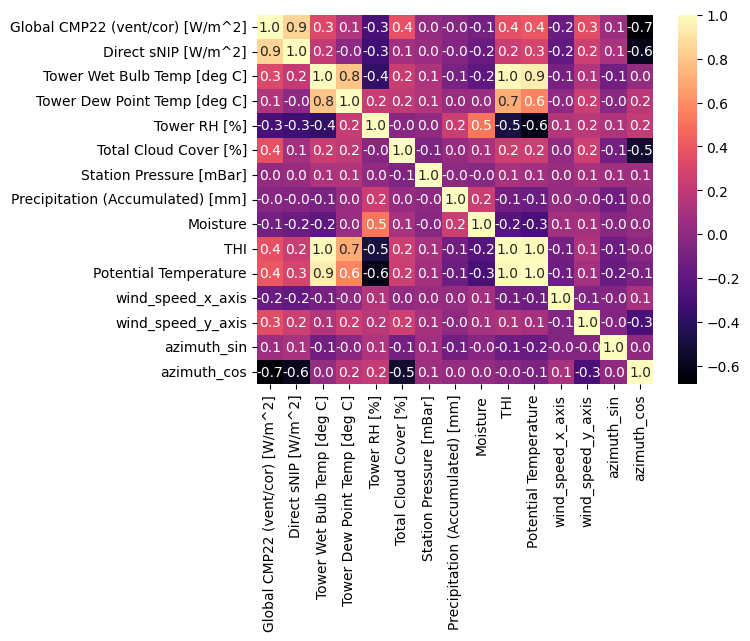

In [189]:
sns.heatmap(train_df.iloc[:, 2:].corr(), annot=True, cbar=True, cmap='magma', fmt='.1f')

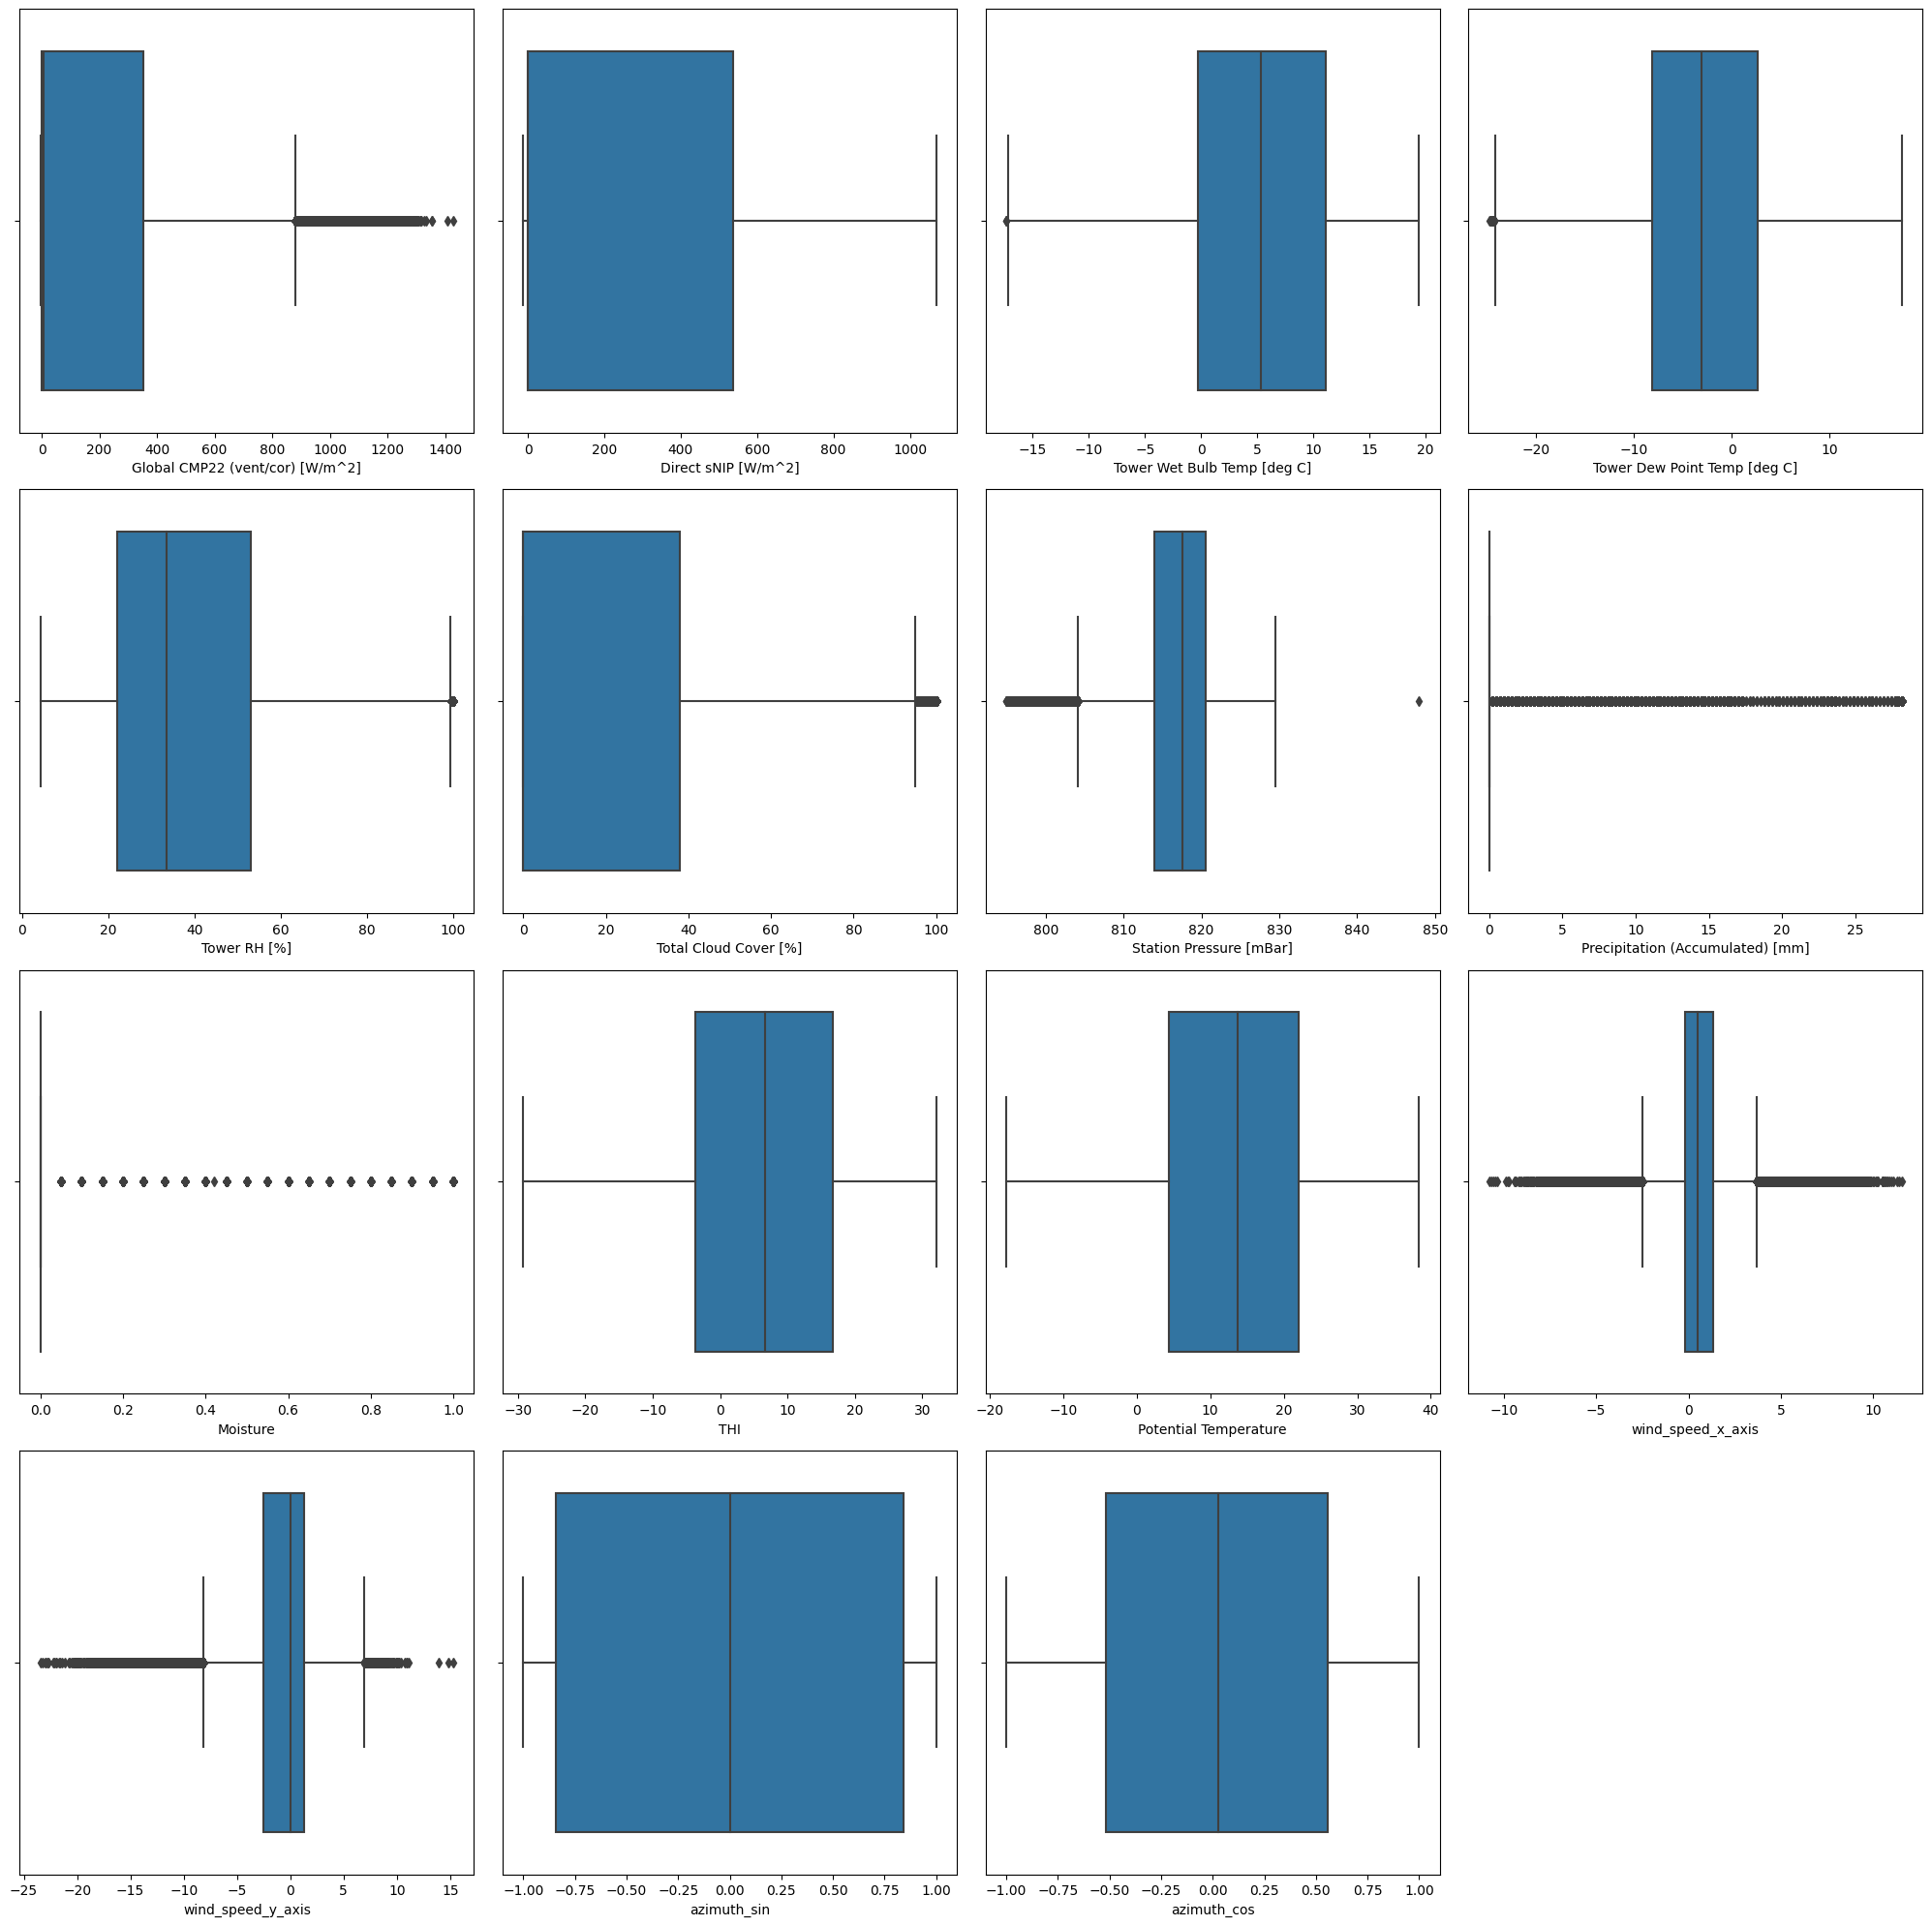

In [190]:
# Making box-plots for all columns to visulize outliers

columns_to_plot = train_df.columns[2:]
num_plots = len(columns_to_plot)
num_rows = (num_plots - 1) // 4 + 1  # Calculate how many rows are needed

fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    sns.boxplot(x=train_df[column], ax=ax)

# Remove any unused subplots (last corner)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

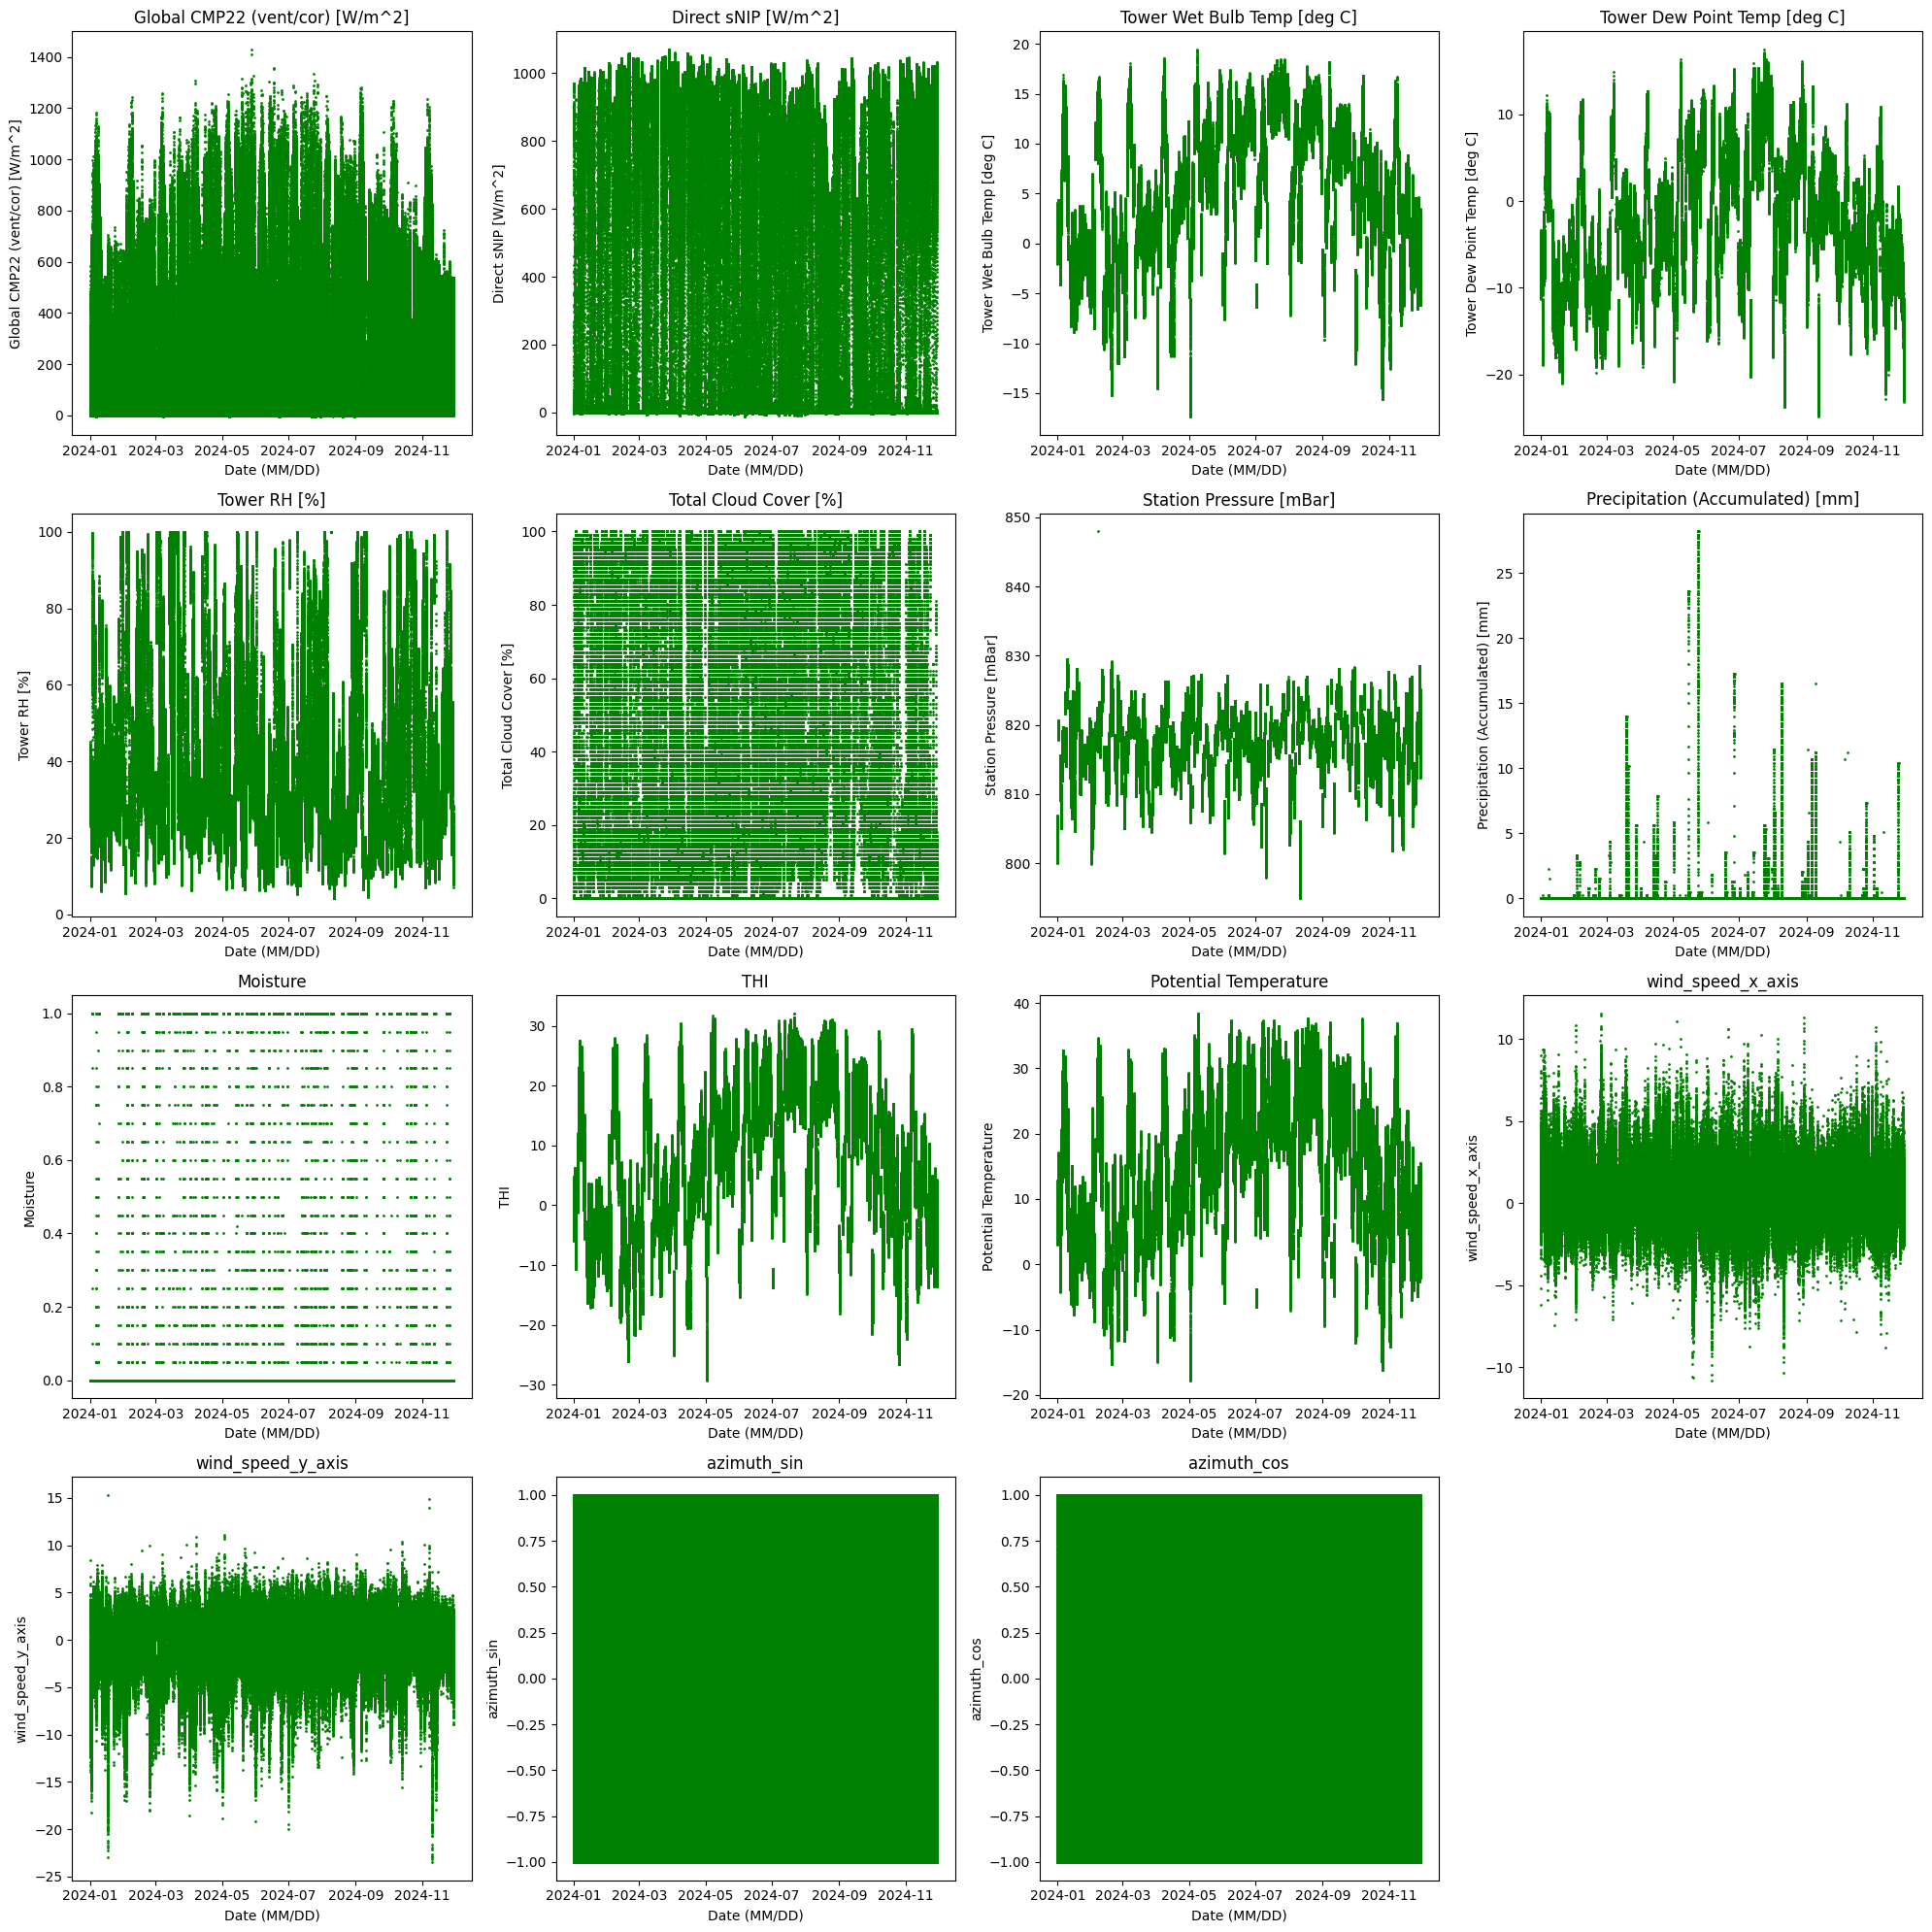

In [191]:
columns_to_plot = train_df.columns[2:]
num_plots = len(columns_to_plot)
num_rows = (num_plots - 1) // 4 + 1  # Calculate how many rows are needed

fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.scatter(train_df['DATE (MM/DD)'], train_df[column], s=1, c='green', marker='o')
    ax.set_title(column)
    ax.set_xlabel('Date (MM/DD)')
    ax.set_ylabel(column)

# Remove any unused subplots (last corner)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Splitting Train and Validation Set

In [243]:
train_X = pd.concat([train_df.iloc[:131040], train_df.iloc[218880:]]) # Jan to March and June to Nov
val_X = train_df.iloc[131040:218880]   # April and May
print(train_X.shape,val_X.shape)

(394560, 17) (87840, 17)


In [244]:
split_column = 'scenario_set'

unique_values = test_df[split_column].unique()

In [245]:
segmented_test_df = []

for value in unique_values:
    segmented_df = test_df[test_df[split_column] == value]
    segmented_test_df.append(segmented_df)
    
len(segmented_test_df)

155

In [246]:
segmented_test_df[0]

,scenario_set,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,Potential Temperature,THI,wind_speed_x_axis,wind_speed_y_axis,azimuth_sin,azimuth_cos
0,0,2024-12-01,07:50:00,54.3644,464.075,-5.3070,-15.6070,27.230,3.0,810.312,0.0,0.0,-0.839977,-11.59352,-0.420918,-0.851662,0.842343,-0.538943
1,0,2024-12-01,07:51:00,56.6827,472.765,-5.1580,-15.6580,26.880,2.0,810.301,0.0,0.0,-0.734850,-11.51288,0.000000,0.000000,0.840768,-0.541396
2,0,2024-12-01,07:52:00,57.8298,477.189,-5.1465,-15.6465,26.775,2.0,810.295,0.0,0.0,-0.670605,-11.44824,0.000000,0.000000,0.839976,-0.542624
3,0,2024-12-01,07:53:00,58.9769,481.613,-5.1350,-15.6350,26.670,2.0,810.289,0.0,0.0,-0.606360,-11.38360,0.000000,0.000000,0.839182,-0.543850
4,0,2024-12-01,07:54:00,61.2684,489.245,-5.1240,-15.6240,26.510,2.0,810.307,0.0,0.0,-0.516093,-11.29464,0.000000,0.000000,0.837587,-0.546305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0,2024-12-01,13:45:00,519.2260,971.904,-2.4950,-18.1950,14.480,25.0,809.390,0.0,0.0,4.804616,-7.21120,-1.872325,-3.191301,-0.295841,-0.955237
356,0,2024-12-01,13:46:00,517.7550,973.199,-2.4890,-17.9890,14.710,24.0,809.367,0.0,0.0,4.862018,-7.08304,-1.633572,-3.319856,-0.300041,-0.953926
357,0,2024-12-01,13:47:00,511.7830,960.571,-2.3170,-17.8170,14.800,24.0,809.329,0.0,0.0,5.017177,-6.87512,0.684780,-5.658717,-0.304229,-0.952599
358,0,2024-12-01,13:48:00,511.5520,963.643,-2.3820,-18.0820,14.370,25.0,809.337,0.0,0.0,5.084087,-6.90752,2.302520,-6.291931,-0.308405,-0.951255


## Scaling Data

In [247]:
train = train_X.iloc[:, 2:] # leaving first 2 columns, DATE (MM/DD) and MST
scalers = {}

for column in train.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(train[column].values.reshape(-1, 1))
    scaled_values = np.reshape(scaled_values, len(scaled_values))
    scalers['scaler_' + column] = scaler
    train[column] = scaled_values

# Applying the same scaling to the validation data
val = val_X.iloc[:, 2:]
for column in train.columns:
    scaler = scalers['scaler_' + column]
    scaled_values = scaler.transform(val[column].values.reshape(-1, 1))
    scaled_values = np.reshape(scaled_values, len(scaled_values))
    val[column] = scaled_values

In [248]:
test = {}
for i in range(len(segmented_test_df)):
    test[i] = segmented_test_df[i].iloc[:, 3:] # leaving first 3 columns: sequence_set, DATE (MM/DD) and MST

    for column in test[i].columns:
        scaler = scalers['scaler_' + column]
        scaled_values = scaler.transform(test[i][column].values.reshape(-1, 1))
        scaled_values = np.reshape(scaled_values, len(scaled_values))
        test[i][column] = scaled_values


In [249]:
train

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,THI,Potential Temperature,wind_speed_x_axis,wind_speed_y_axis,azimuth_sin,azimuth_cos
0,0.002794,0.011468,0.487074,0.414647,0.293253,0.0,0.223603,0.0,0.0,0.442214,0.442494,0.492948,0.348494,0.472581,0.999248
1,0.002812,0.011468,0.488598,0.415878,0.293983,0.0,0.224753,0.0,0.0,0.443130,0.443183,0.501410,0.393866,0.479542,0.999581
2,0.002807,0.011468,0.490152,0.417132,0.295443,0.0,0.225431,0.0,0.0,0.443541,0.443280,0.579448,0.441535,0.486514,0.999818
3,0.002802,0.011440,0.489185,0.411617,0.288664,0.0,0.224432,0.0,0.0,0.442076,0.443243,0.622965,0.423681,0.493492,0.999958
4,0.002814,0.011417,0.489800,0.412114,0.287517,0.0,0.223282,0.0,0.0,0.443519,0.444768,0.568932,0.426163,0.500473,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482395,0.002450,0.011376,0.424878,0.238970,0.143289,0.0,0.333849,0.0,0.0,0.377466,0.420052,0.519976,0.538921,0.534173,0.998831
482396,0.002456,0.011326,0.419603,0.218141,0.129315,0.0,0.333773,0.0,0.0,0.371071,0.418908,0.539247,0.529322,0.540725,0.998339
482397,0.002497,0.011376,0.419251,0.206022,0.119303,0.0,0.333641,0.0,0.0,0.370861,0.422301,0.528295,0.540668,0.547260,0.997761
482398,0.002507,0.011426,0.425963,0.225644,0.130566,0.0,0.333604,0.0,0.0,0.378512,0.425259,0.537999,0.536062,0.553775,0.997100


In [250]:
val

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,THI,Potential Temperature,wind_speed_x_axis,wind_speed_y_axis,azimuth_sin,azimuth_cos
4320,0.002789,0.011298,0.457002,0.385628,0.289603,0.0,0.456970,0.0,0.0,0.410831,0.414366,0.591024,0.472011,0.463358,0.998656
4321,0.002801,0.011294,0.458087,0.386504,0.290437,0.0,0.457046,0.0,0.0,0.411246,0.414582,0.558206,0.478260,0.470207,0.999112
4322,0.002778,0.011294,0.456592,0.385296,0.289498,0.0,0.457329,0.0,0.0,0.410506,0.414090,0.572697,0.453842,0.477070,0.999474
4323,0.002778,0.011280,0.458028,0.384089,0.287517,0.0,0.453785,0.0,0.0,0.410551,0.414511,0.557086,0.352024,0.483945,0.999742
4324,0.002781,0.011253,0.458028,0.384089,0.286683,0.0,0.454030,0.0,0.0,0.411183,0.415238,0.565416,0.379202,0.490826,0.999916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218875,0.002613,0.011285,0.804209,0.713596,0.336114,0.0,0.446055,0.0,0.0,0.750532,0.708076,0.536319,0.535624,0.491738,0.999932
218876,0.002594,0.011285,0.804326,0.713691,0.336219,0.0,0.446263,0.0,0.0,0.750557,0.708075,0.549619,0.532176,0.494029,0.999964
218877,0.002611,0.011280,0.804414,0.714235,0.337053,0.0,0.447111,0.0,0.0,0.750528,0.707872,0.553166,0.548573,0.496320,0.999986
218878,0.002612,0.011271,0.802802,0.714590,0.338409,0.0,0.447243,0.0,0.0,0.749937,0.707083,0.522021,0.567625,0.498612,0.999998


In [251]:
len(test)

155

In [252]:
test[0]

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,Potential Temperature,THI,wind_speed_x_axis,wind_speed_y_axis,azimuth_sin,azimuth_cos
0,0.043457,0.440530,0.302568,0.218306,0.240067,0.03,0.290206,0.0,0.0,0.284269,0.254651,0.464018,0.583253,0.921171,0.230529
1,0.045161,0.448564,0.306935,0.217099,0.236417,0.02,0.289999,0.0,0.0,0.286223,0.256027,0.482849,0.605235,0.920384,0.229302
2,0.046004,0.452654,0.307272,0.217371,0.235322,0.02,0.289886,0.0,0.0,0.287417,0.257130,0.482849,0.605235,0.919988,0.228688
3,0.046847,0.456744,0.307609,0.217643,0.234227,0.02,0.289773,0.0,0.0,0.288612,0.258232,0.482849,0.605235,0.919591,0.228075
4,0.048531,0.463801,0.307931,0.217904,0.232558,0.02,0.290112,0.0,0.0,0.290289,0.259750,0.482849,0.605235,0.918793,0.226848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.385110,0.910045,0.384987,0.157049,0.107102,0.25,0.272825,0.0,0.0,0.389189,0.329421,0.399084,0.522868,0.352079,0.022381
356,0.384029,0.911242,0.385163,0.161925,0.109500,0.24,0.272391,0.0,0.0,0.390256,0.331607,0.409765,0.519550,0.349980,0.023037
357,0.379640,0.899567,0.390205,0.165996,0.110439,0.24,0.271675,0.0,0.0,0.393140,0.335155,0.513485,0.459185,0.347886,0.023700
358,0.379470,0.902407,0.388299,0.159724,0.105955,0.25,0.271826,0.0,0.0,0.394384,0.334602,0.585861,0.442841,0.345798,0.024372


## Sequencing Data
To input 90 minutes (1.5 hours) of data and get output predictions of the next 15th, 25th and 30th minute, cloud cover percentage.

In [253]:
# data --> train and val
# past_steps --> kitne minutes ki information feed karwana chahate hai
# future_steps  --> kitne minutes ki information forecast karwana chahate hai

def split_time_series(data, past_steps, future_pred):
    X, y = list(), list()
    for start_index in range(len(data)):
        end_past_index = start_index + past_steps
        future_indices = [end_past_index + interval for interval in future_pred]
        if max(future_indices) >= len(data):
            break
        past_sequence = data[start_index:end_past_index, :] # We can include cloud cover percentage column as well
#         past_sequence = np.delete(past_sequence, 5, axis=1) 
        future_sequence = data[future_indices, 5] 
        X.append(past_sequence)
        y.append(future_sequence)
    return np.array(X), np.array(y)


# Preparing X_train, y_train, X_val and y_val

past_steps = 90  # 1.5 hours of past data
future_pred = [15, 25, 30]  # Predictions for the 15th, 25th, and 30th minutes
n_features = 15  # 14 features present in train, val

X_train, y_train = split_time_series(train.values, past_steps, future_pred)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], len(future_pred), 1))

X_val, y_val = split_time_series(val.values, past_steps, future_pred)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
y_val = y_val.reshape((y_val.shape[0], len(future_pred), 1))

In [254]:
shape = (155, 360, 15)

X_test = np.zeros(shape)

for index in range(155):
    if index in test:
        X_test[index] = np.array(test[index])

In [255]:
X_test.shape

(155, 360, 15)

In [256]:
X_train.shape, y_train.shape

((394440, 90, 15), (394440, 3, 1))

So, X_test should be like, 155, 360, 14 and y_test should be like 155, 3, 1 then we will append scenario set to starting of y_test for submission.csv to make it 155, 4, 1

In [257]:
cloud_cover_column = X_test[:, :, 5]
cloud_cover_column

array([[0.03      , 0.02      , 0.02      , ..., 0.24      , 0.25      ,
        0.24      ],
       [0.23322581, 0.22645161, 0.21967742, ..., 0.21      , 0.21      ,
        0.21      ],
       [0.20548387, 0.20096774, 0.19645161, ..., 0.28      , 0.29      ,
        0.29      ],
       ...,
       [0.70935484, 0.68870968, 0.66806452, ..., 0.79      , 0.8       ,
        0.81      ],
       [0.78645161, 0.76290323, 0.73935484, ..., 0.73      , 0.73      ,
        0.69      ],
       [0.66967742, 0.64935484, 0.62903226, ..., 0.48      , 0.47      ,
        0.42      ]])

In [258]:
X_test = X_test[:, 270:, :]
print(X_test.shape)  # Output should be (155, 90, 14)

(155, 90, 15)


In [71]:
filename = 'prepdata.pkl'

data_dict = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val
}

with open(filename, 'wb') as f:
    pickle.dump(data_dict, f)

print(f"Dataframes saved to '{filename}'")


Dataframes saved to 'prepdata.pkl'


# Time Series Forecasting Models Implementation

## 1) Simple RNN

In [77]:
filename = '/kaggle/working/prepdata.pkl'
X_train, y_train, X_val, y_val = load_dataframes(filename)

In [78]:
n_past = 90
n_features = 15

In [79]:
model_RNN = Sequential()

model_RNN.add(SimpleRNN(128, activation = 'relu', input_shape=(n_past, n_features), return_sequences=True))
# model_RNN.add(Dropout(0.3))

model_RNN.add(SimpleRNN(64, return_sequences=True))
model_RNN.add(SimpleRNN(64, return_sequences=True))
model_RNN.add(Dropout(0.3))

# model_RNN.add(SimpleRNN(32, return_sequences=True))

model_RNN.add(SimpleRNN(25, activation = 'relu', return_sequences=False))
# model_RNN.add(Dropout(0.2))

model_RNN.add(Dense(3))

model_RNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 90, 128)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 90, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 90, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 25)             │         2,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,368 (161.59 KB)

 Trainable params: 41,368 (161.59 KB)

 Non-trainable params: 0 (0.00 B)

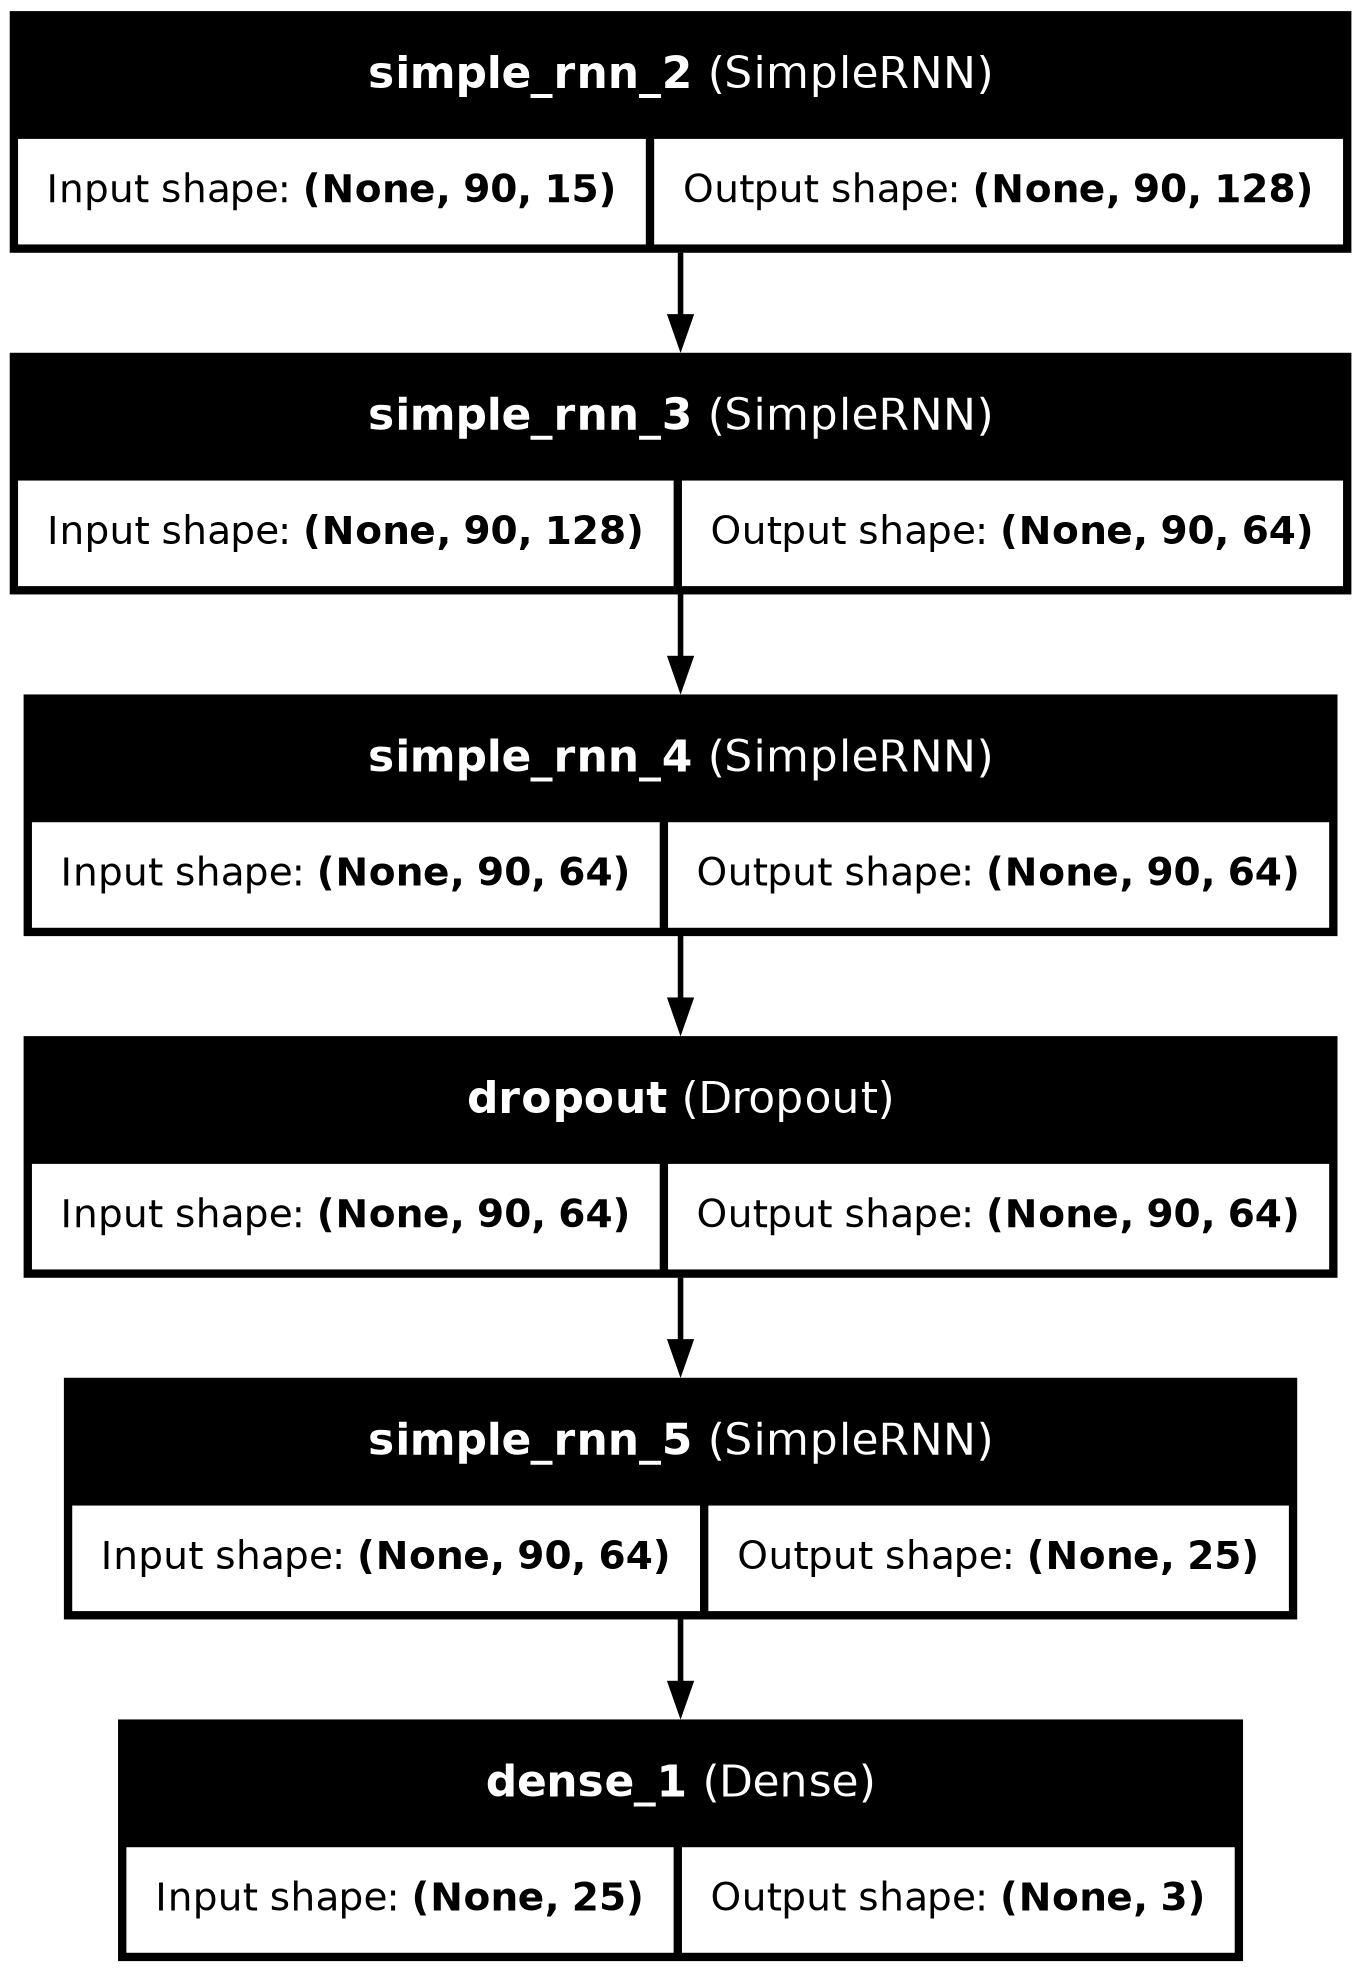

In [80]:
plot_model(model_RNN, to_file='RNN_plot.png', show_shapes=True, show_layer_names=True)

In [81]:
model_RNN.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.R2Score(),
                            tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_rnn_final.keras', save_best_only=True, monitor='val_loss')

history = model_RNN.fit(X_train, y_train, 
                              epochs=15, 
                              validation_data=(X_val, y_val), 
                              batch_size=128, 
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint])

model_RNN.save('model_rnnfinal_.keras')

Epoch 1/15
3082/3082 ━━━━━━━━━━━━━━━━━━━━ 121s 37ms/step - loss: 0.0203 - mean_absolute_error: 0.0749 - mean_squared_error: 0.0203 - r2_score: 0.8328 - root_mean_squared_error: 0.1378 - val_loss: 0.0154 - val_mean_absolute_error: 0.0631 - val_mean_squared_error: 0.0154 - val_r2_score: 0.8680 - val_root_mean_squared_error: 0.1241
Epoch 2/15
3082/3082 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.0104 - mean_absolute_error: 0.0497 - mean_squared_error: 0.0104 - r2_score: 0.9147 - root_mean_squared_error: 0.1021 - val_loss: 0.0137 - val_mean_absolute_error: 0.0562 - val_mean_squared_error: 0.0137 - val_r2_score: 0.8826 - val_root_mean_squared_error: 0.1170
Epoch 3/15
3082/3082 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - loss: 0.0096 - mean_absolute_error: 0.0468 - mean_squared_error: 0.0096 - r2_score: 0.9216 - root_mean_squared_error: 0.0979 - val_loss: 0.0138 - val_mean_absolute_error: 0.0562 - val_mean_squared_error: 0.0138 - val_r2_score: 0.8813 - val_root_mean_squared_error: 0.1177
Epoch 4

### Simple RNN Prediction and Scoring

In [82]:
primary_path = '/kaggle/working/model_rnn.keras'
fallback_path = '/kaggle/input/ccd-result/results/model_rnn.keras'

try:
    model_RNN = load_model(primary_path)
except:
    model_RNN = load_model(fallback_path)
    
pred_RNN=model_RNN.predict(X_val)
print(pred_RNN.shape, y_train.shape, y_val.shape)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
(87720, 3) (394440, 3, 1) (87720, 3, 1)


In [83]:
scaler = scalers['scaler_Total Cloud Cover [%]']
pred_RNN[:,:]=scaler.inverse_transform(pred_RNN[:,:])
y_train[:,:,0]=scaler.inverse_transform(y_train[:,:,0])
y_val[:,:,0]=scaler.inverse_transform(y_val[:,:,0])

In [84]:
print("MAE-15: ",mean_absolute_error(y_val[:,0,0],pred_RNN[:,0]))
print("MAE-25: ",mean_absolute_error(y_val[:,1,0],pred_RNN[:,1]))
print("MAE-30: ",mean_absolute_error(y_val[:,2,0],pred_RNN[:,2]))

print("R2-score-15: ", r2_score(y_val[:,0,0],pred_RNN[:,0]))
print("R2-score-25: ", r2_score(y_val[:,1,0],pred_RNN[:,1]))
print("R2-score-30: ", r2_score(y_val[:,2,0],pred_RNN[:,2]))

print("MSE-15: ", mean_squared_error(y_val[:,0,0],pred_RNN[:,0]))
print("MSE-25: ", mean_squared_error(y_val[:,1,0],pred_RNN[:,1]))
print("MSE-30: ", mean_squared_error(y_val[:,2,0],pred_RNN[:,2]))

MAE-15:  3.2178438610306523
MAE-25:  4.092379337474195
MAE-30:  4.462379271840593
R2-score-15:  0.9290506244500276
R2-score-25:  0.8796737595779698
R2-score-30:  0.8562905989144681
MSE-15:  50.32419582772038
MSE-25:  85.34706950234697
MSE-30:  101.93268068186022


In [85]:
w_mae = (mean_absolute_error(y_val[:,0,0],pred_RNN[:,0]) * .5) + (mean_absolute_error(y_val[:,1,0],pred_RNN[:,1]) * .35) + (mean_absolute_error(y_val[:,2,0],pred_RNN[:,2]) * .15)
w_r2 = (r2_score(y_val[:,0,0],pred_RNN[:,0]) * .5) + (r2_score(y_val[:,1,0],pred_RNN[:,1]) * .35) + (r2_score(y_val[:,2,0],pred_RNN[:,2]) * .15)
w_mse = (mean_squared_error(y_val[:,0,0],pred_RNN[:,0]) * 0.5) + (mean_squared_error(y_val[:,1,0],pred_RNN[:,1]) * 0.35) + (mean_squared_error(y_val[:,2,0],pred_RNN[:,2]) * 0.15)

print("Weighted MAE: ", w_mae)
print("Weighted R2 Score: ", w_r2)
print("Weighted MSE: ", w_mse)

Weighted MAE:  3.7106115894073834
Weighted R2 Score:  0.9008547179144734
Weighted MSE:  70.32347434196066


### Training Curve

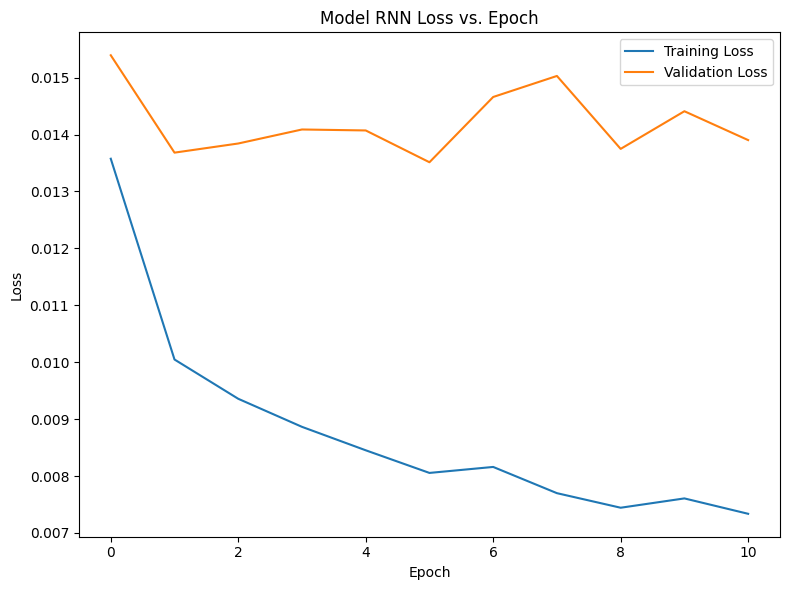

In [86]:
plot_history(history, 'Model RNN')

## 2) GRU (Gated Recurrent Unit)

In [100]:
filename = '/kaggle/working/prepdata.pkl'
X_train, y_train, X_val, y_val = load_dataframes(filename)

In [101]:
n_past = 90
n_features = 15

model_GRU = Sequential()

model_GRU.add(GRU(128, input_shape=(n_past, n_features), return_sequences=True))
model_GRU.add(Dropout(0.3))

model_GRU.add(GRU(64, return_sequences=True))
model_GRU.add(Dropout(0.3))

model_GRU.add(GRU(32, return_sequences=False))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(128))
model_GRU.add(Dense(128))
model_GRU.add(Dense(64))
model_GRU.add(Dense(64))
model_GRU.add(Dense(3))

model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 90, 128)        │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 90, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,683 (530.01 KB)

 Trainable params: 135,683 (530.01 KB)

 Non-trainable params: 0 (0.00 B)

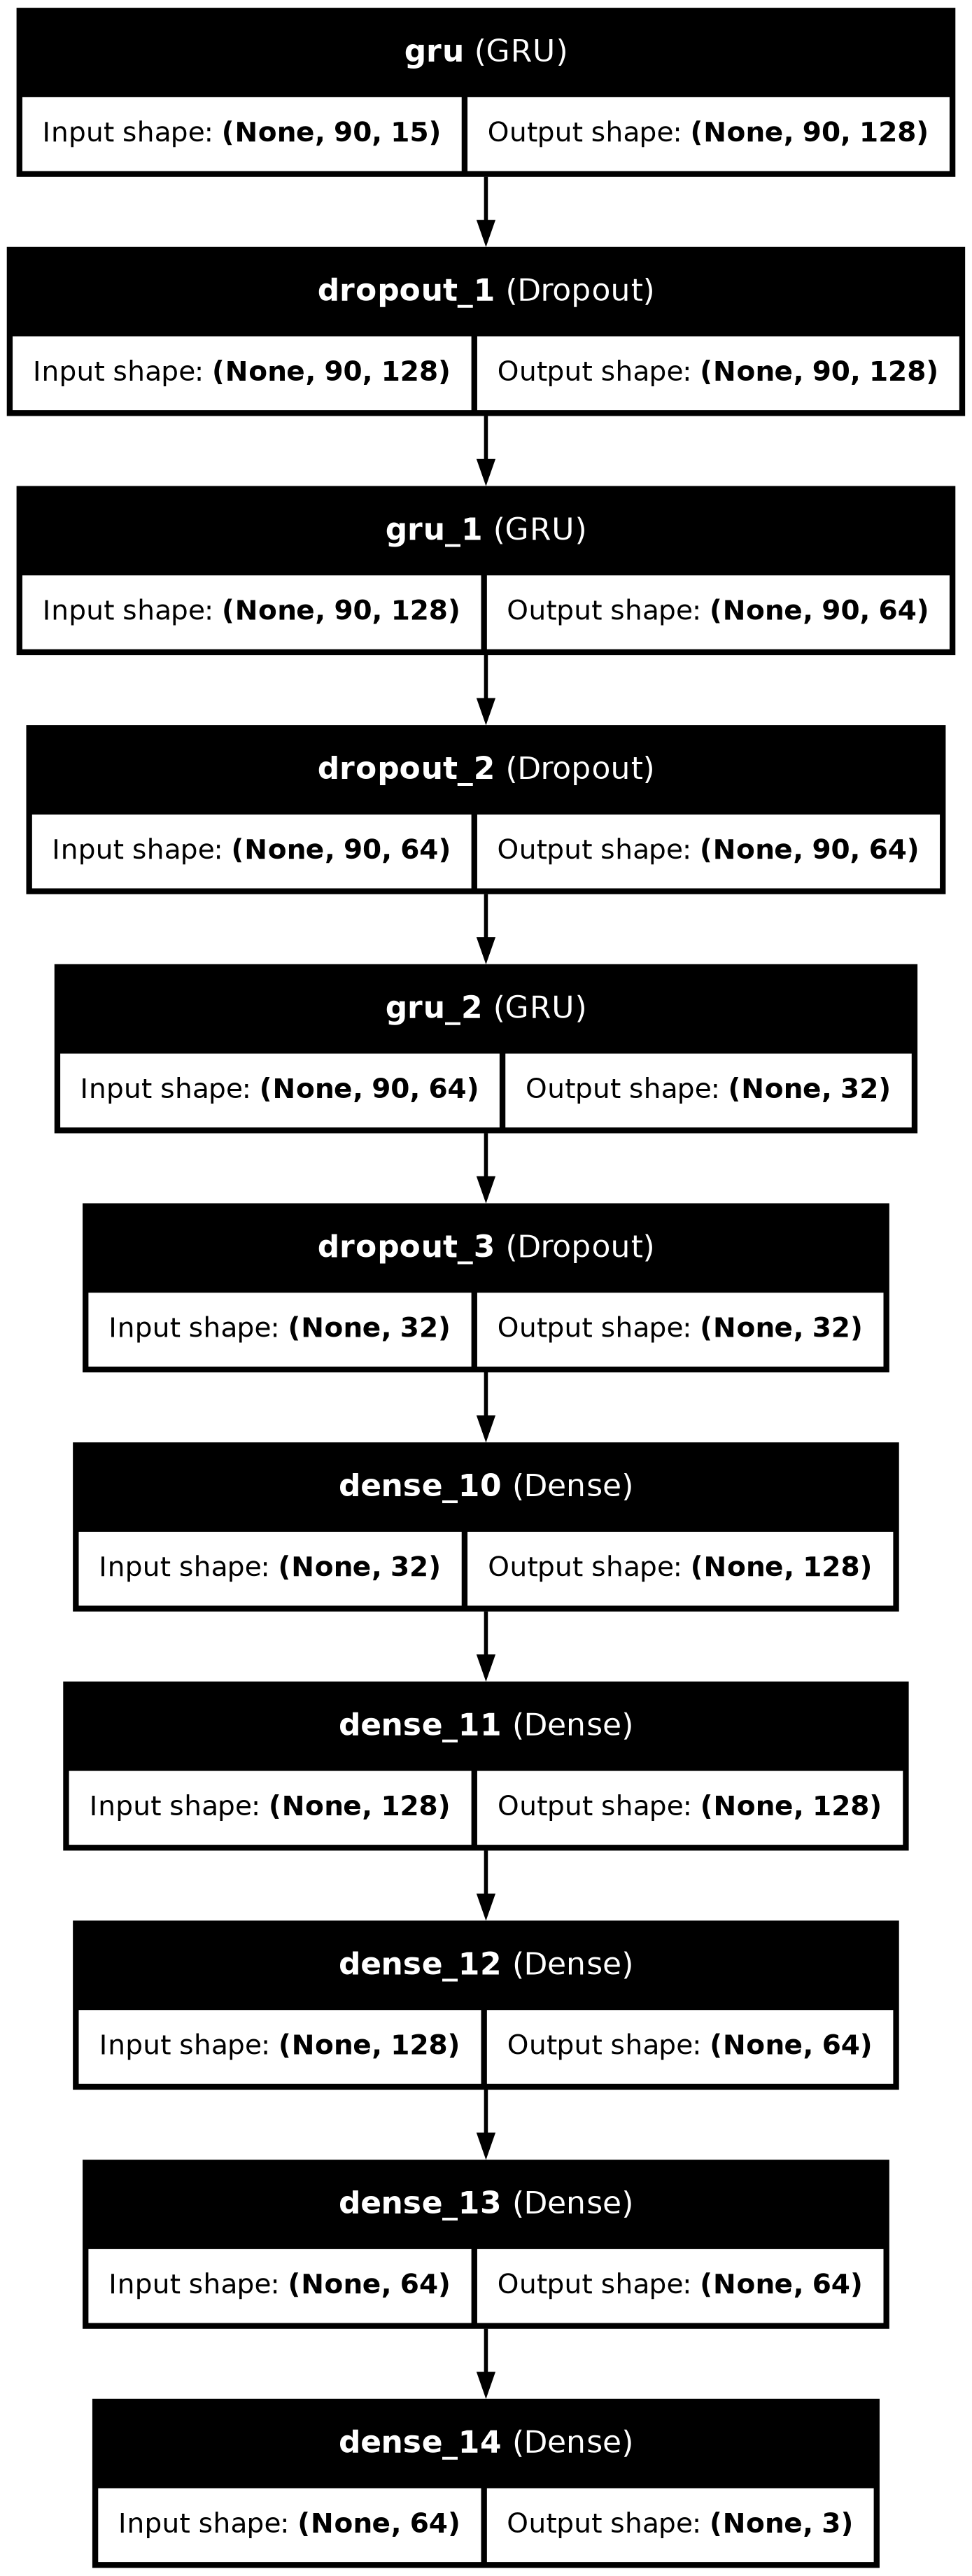

In [102]:
plot_model(model_GRU, to_file='GRU_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_GRU.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.MeanAbsoluteError(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.R2Score(),
                            tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_gru.keras', save_best_only=True, monitor='val_loss')

history_GRU = model_GRU.fit(X_train, y_train, 
                              epochs=15, 
                              validation_data=(X_val, y_val), 
                              batch_size=32, 
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint])

model_GRU.save('model_gru_.keras')

Epoch 1/15
12327/12327 ━━━━━━━━━━━━━━━━━━━━ 238s 19ms/step - loss: 0.0639 - mean_absolute_error: 0.0639 - mean_squared_error: 0.0169 - r2_score: 0.8603 - root_mean_squared_error: 0.1298 - val_loss: 0.0535 - val_mean_absolute_error: 0.0535 - val_mean_squared_error: 0.0143 - val_r2_score: 0.8775 - val_root_mean_squared_error: 0.1195
Epoch 2/15
12327/12327 ━━━━━━━━━━━━━━━━━━━━ 233s 19ms/step - loss: 0.0513 - mean_absolute_error: 0.0513 - mean_squared_error: 0.0128 - r2_score: 0.8950 - root_mean_squared_error: 0.1130 - val_loss: 0.0529 - val_mean_absolute_error: 0.0529 - val_mean_squared_error: 0.0141 - val_r2_score: 0.8795 - val_root_mean_squared_error: 0.1185
Epoch 3/15
12327/12327 ━━━━━━━━━━━━━━━━━━━━ 264s 19ms/step - loss: 0.0553 - mean_absolute_error: 0.0553 - mean_squared_error: 0.0149 - r2_score: 0.8780 - root_mean_squared_error: 0.1219 - val_loss: 0.0593 - val_mean_absolute_error: 0.0593 - val_mean_squared_error: 0.0168 - val_r2_score: 0.8561 - val_root_mean_squared_error: 0.1295
E

### GRU Predictions and Scoring

In [ ]:
primary_path = '/kaggle/working/model_gru.keras'
fallback_path = '/kaggle/input/ccd-result/results/model_gru.keras'

try:
    model_GRU = load_model(primary_path)
except:
    model_GRU = load_model(fallback_path)
    
pred_GRU=model_GRU.predict(X_val)
print(pred_GRU.shape, y_train.shape, y_val.shape)

In [ ]:
scaler = scalers['scaler_Total Cloud Cover [%]']
pred_GRU[:,:]=scaler.inverse_transform(pred_GRU[:,:])
y_train[:,:,0]=scaler.inverse_transform(y_train[:,:,0])
y_val[:,:,0]=scaler.inverse_transform(y_val[:,:,0])

In [ ]:
print("MAE-15: ",mean_absolute_error(y_val[:,0,0],pred_GRU[:,0]))
print("MAE-25: ",mean_absolute_error(y_val[:,1,0],pred_GRU[:,1]))
print("MAE-30: ",mean_absolute_error(y_val[:,2,0],pred_GRU[:,2]))

print("R2-score-15: ", r2_score(y_val[:,0,0],pred_GRU[:,0]))
print("R2-score-25: ", r2_score(y_val[:,1,0],pred_GRU[:,1]))
print("R2-score-30: ", r2_score(y_val[:,2,0],pred_GRU[:,2]))

print("MSE-15: ", mean_squared_error(y_val[:,0,0],pred_GRU[:,0]))
print("MSE-25: ", mean_squared_error(y_val[:,1,0],pred_GRU[:,1]))
print("MSE-30: ", mean_squared_error(y_val[:,2,0],pred_GRU[:,2]))

In [ ]:
w_mae = mean_absolute_error(y_val[:,0,0],pred_GRU[:,0]) * .5 + mean_absolute_error(y_val[:,1,0],pred_GRU[:,1]) * .35 + mean_absolute_error(y_val[:,2,0],pred_GRU[:,2]) * .15
w_r2 = r2_score(y_val[:,0,0],pred_GRU[:,0]) * .5 + r2_score(y_val[:,1,0],pred_GRU[:,1]) * .35 + r2_score(y_val[:,2,0],pred_GRU[:,2]) * .15
w_mse = (mean_squared_error(y_val[:,0,0],pred_GRU[:,0]) * 0.5) + (mean_squared_error(y_val[:,1,0],pred_GRU[:,1]) * 0.35) + (mean_squared_error(y_val[:,2,0],pred_GRU[:,2]) * 0.15)

print("Weighted MAE: ", w_mae)
print("Weighted R2 Score: ", w_r2)
print("Weighted MSE: ", w_mse)

### Training Curve

In [ ]:
plot_history(history_GRU, 'Model GRU')

## 3) LSTM (Long Short Term Memory)

In [ ]:
filename = '/kaggle/working/prepdata.pkl'
X_train, y_train, X_val, y_val = load_dataframes(filename)

In [ ]:
n_past = 90
n_features = 15

model_LSTM = Sequential()

model_LSTM.add(LSTM(128, input_shape=(n_past, n_features), return_sequences=True))
model_LSTM.add(Dropout(0.3))

model_LSTM.add(LSTM(64, return_sequences=True))
model_LSTM.add(Dropout(0.3))

model_LSTM.add(LSTM(32, return_sequences=False))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(128))
model_LSTM.add(Dense(128))
model_LSTM.add(Dense(64))
model_LSTM.add(Dense(64))
model_LSTM.add(Dense(3))

model_LSTM.summary()

In [ ]:
plot_model(model_LSTM, to_file='LSTM_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.R2Score(),
                            tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_lstm.keras', save_best_only=True, monitor='val_loss')

history_LSTM = model_LSTM.fit(X_train, y_train, 
                              epochs=15, 
                              validation_data=(X_val, y_val), 
                              batch_size=32, 
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint])

model_LSTM.save('model_lstm_.keras')

### LSTM Predictions and Scoring

In [ ]:
primary_path = '/kaggle/working/model_lstm.keras'
fallback_path = '/kaggle/input/ccd-result/results/model_lstm.keras'

try:
    model_LSTM = load_model(primary_path)
except:
    model_LSTM = load_model(fallback_path)
    
pred_LSTM = model_LSTM.predict(X_val)
print(pred_LSTM.shape, y_train.shape, y_val.shape)

In [ ]:
scaler = scalers['scaler_Total Cloud Cover [%]']
pred_LSTM[:,:]=scaler.inverse_transform(pred_LSTM[:,:])
y_train[:,:,0]=scaler.inverse_transform(y_train[:,:,0])
y_val[:,:,0]=scaler.inverse_transform(y_val[:,:,0])

In [ ]:
print("MAE-15: ",mean_absolute_error(y_val[:,0,0],pred_LSTM[:,0]))
print("MAE-25: ",mean_absolute_error(y_val[:,1,0],pred_LSTM[:,1]))
print("MAE-30: ",mean_absolute_error(y_val[:,2,0],pred_LSTM[:,2]))

print("R2-score-15: ", r2_score(y_val[:,0,0],pred_LSTM[:,0]))
print("R2-score-25: ", r2_score(y_val[:,1,0],pred_LSTM[:,1]))
print("R2-score-30: ", r2_score(y_val[:,2,0],pred_LSTM[:,2]))

print("MSE-15: ", mean_squared_error(y_val[:,0,0],pred_LSTM[:,0]))
print("MSE-25: ", mean_squared_error(y_val[:,1,0],pred_LSTM[:,1]))
print("MSE-30: ", mean_squared_error(y_val[:,2,0],pred_LSTM[:,2]))

In [ ]:
w_mae = mean_absolute_error(y_val[:,0,0],pred_LSTM[:,0]) * .5 + mean_absolute_error(y_val[:,1,0],pred_LSTM[:,1]) * .35 + mean_absolute_error(y_val[:,2,0],pred_LSTM[:,2]) * .15
w_r2 = r2_score(y_val[:,0,0],pred_LSTM[:,0]) * .5 + r2_score(y_val[:,1,0],pred_LSTM[:,1]) * .35 + r2_score(y_val[:,2,0],pred_LSTM[:,2]) * .15
w_mse = (mean_squared_error(y_val[:,0,0],pred_LSTM[:,0]) * 0.5) + (mean_squared_error(y_val[:,1,0],pred_LSTM[:,1]) * 0.35) + (mean_squared_error(y_val[:,2,0],pred_LSTM[:,2]) * 0.15)

print("Weighted MAE: ", w_mae)
print("Weighted R2 Score: ", w_r2)
print("Weighted MSE: ", w_mse)

### Training Curve

In [ ]:
plot_history(history_LSTM, 'Model LSTM')

## 4) LSTM with Concat

In [87]:
filename = '/kaggle/working/prepdata.pkl'
X_train, y_train, X_val, y_val = load_dataframes(filename)

In [92]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

n_past = 90
n_features = 15
output_shape = 3

def lstm_model(n_past, n_features, output_shape):
    input_shape = (n_past, n_features)
    inputs = Input(shape=input_shape)
    
    lstm1 = LSTM(64, return_sequences=True)(inputs)
    lstm2 = LSTM(64, return_sequences=True)(inputs)
    
    concat1 = Concatenate()([lstm1, lstm2])
    layer1 = Dense(32, activation='relu')(concat1)
    
    lstm3 = LSTM(32, return_sequences=True)(layer1)
    lstm4 = LSTM(32, return_sequences=True)(layer1)
    
    concat2 = Concatenate()([lstm3, lstm4])
    layer2 = Dense(16, activation='relu')(concat2)
    
    lstm5 = LSTM(16, return_sequences=False)(layer2)
    lstm6 = LSTM(16, return_sequences=False)(layer2)
    
    concat3 = Concatenate()([lstm5, lstm6])
    layer3 = Dense(8, activation='relu')(concat3)
    
    out = Dense(output_shape, activation='relu')(layer3)
    
    model = Model(inputs=inputs, outputs=out, name='LSTM_Model')
    
    return model

model_con = lstm_model(n_past, n_features, output_shape)
model_con.summary()

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 90, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 90, 64)    │     20,480 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 90, 64)    │     20,480 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 90, 128)   │          0 │ lstm_6[0][0],     │
│ (Concatenate)       │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 90, 32)    │      4,128 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 90, 32)    │      8,320 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 90, 32)    │      8,320 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 90, 64)    │          0 │ lstm_8[0][0],     │
│ (Concatenate)       │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 90, 16)    │      1,040 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 16)        │      2,112 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 16)        │      2,112 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 32)        │          0 │ lstm_10[0][0],    │
│ (Concatenate)       │                   │            │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        264 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │         27 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,283 (262.82 KB)

 Trainable params: 67,283 (262.82 KB)

 Non-trainable params: 0 (0.00 B)

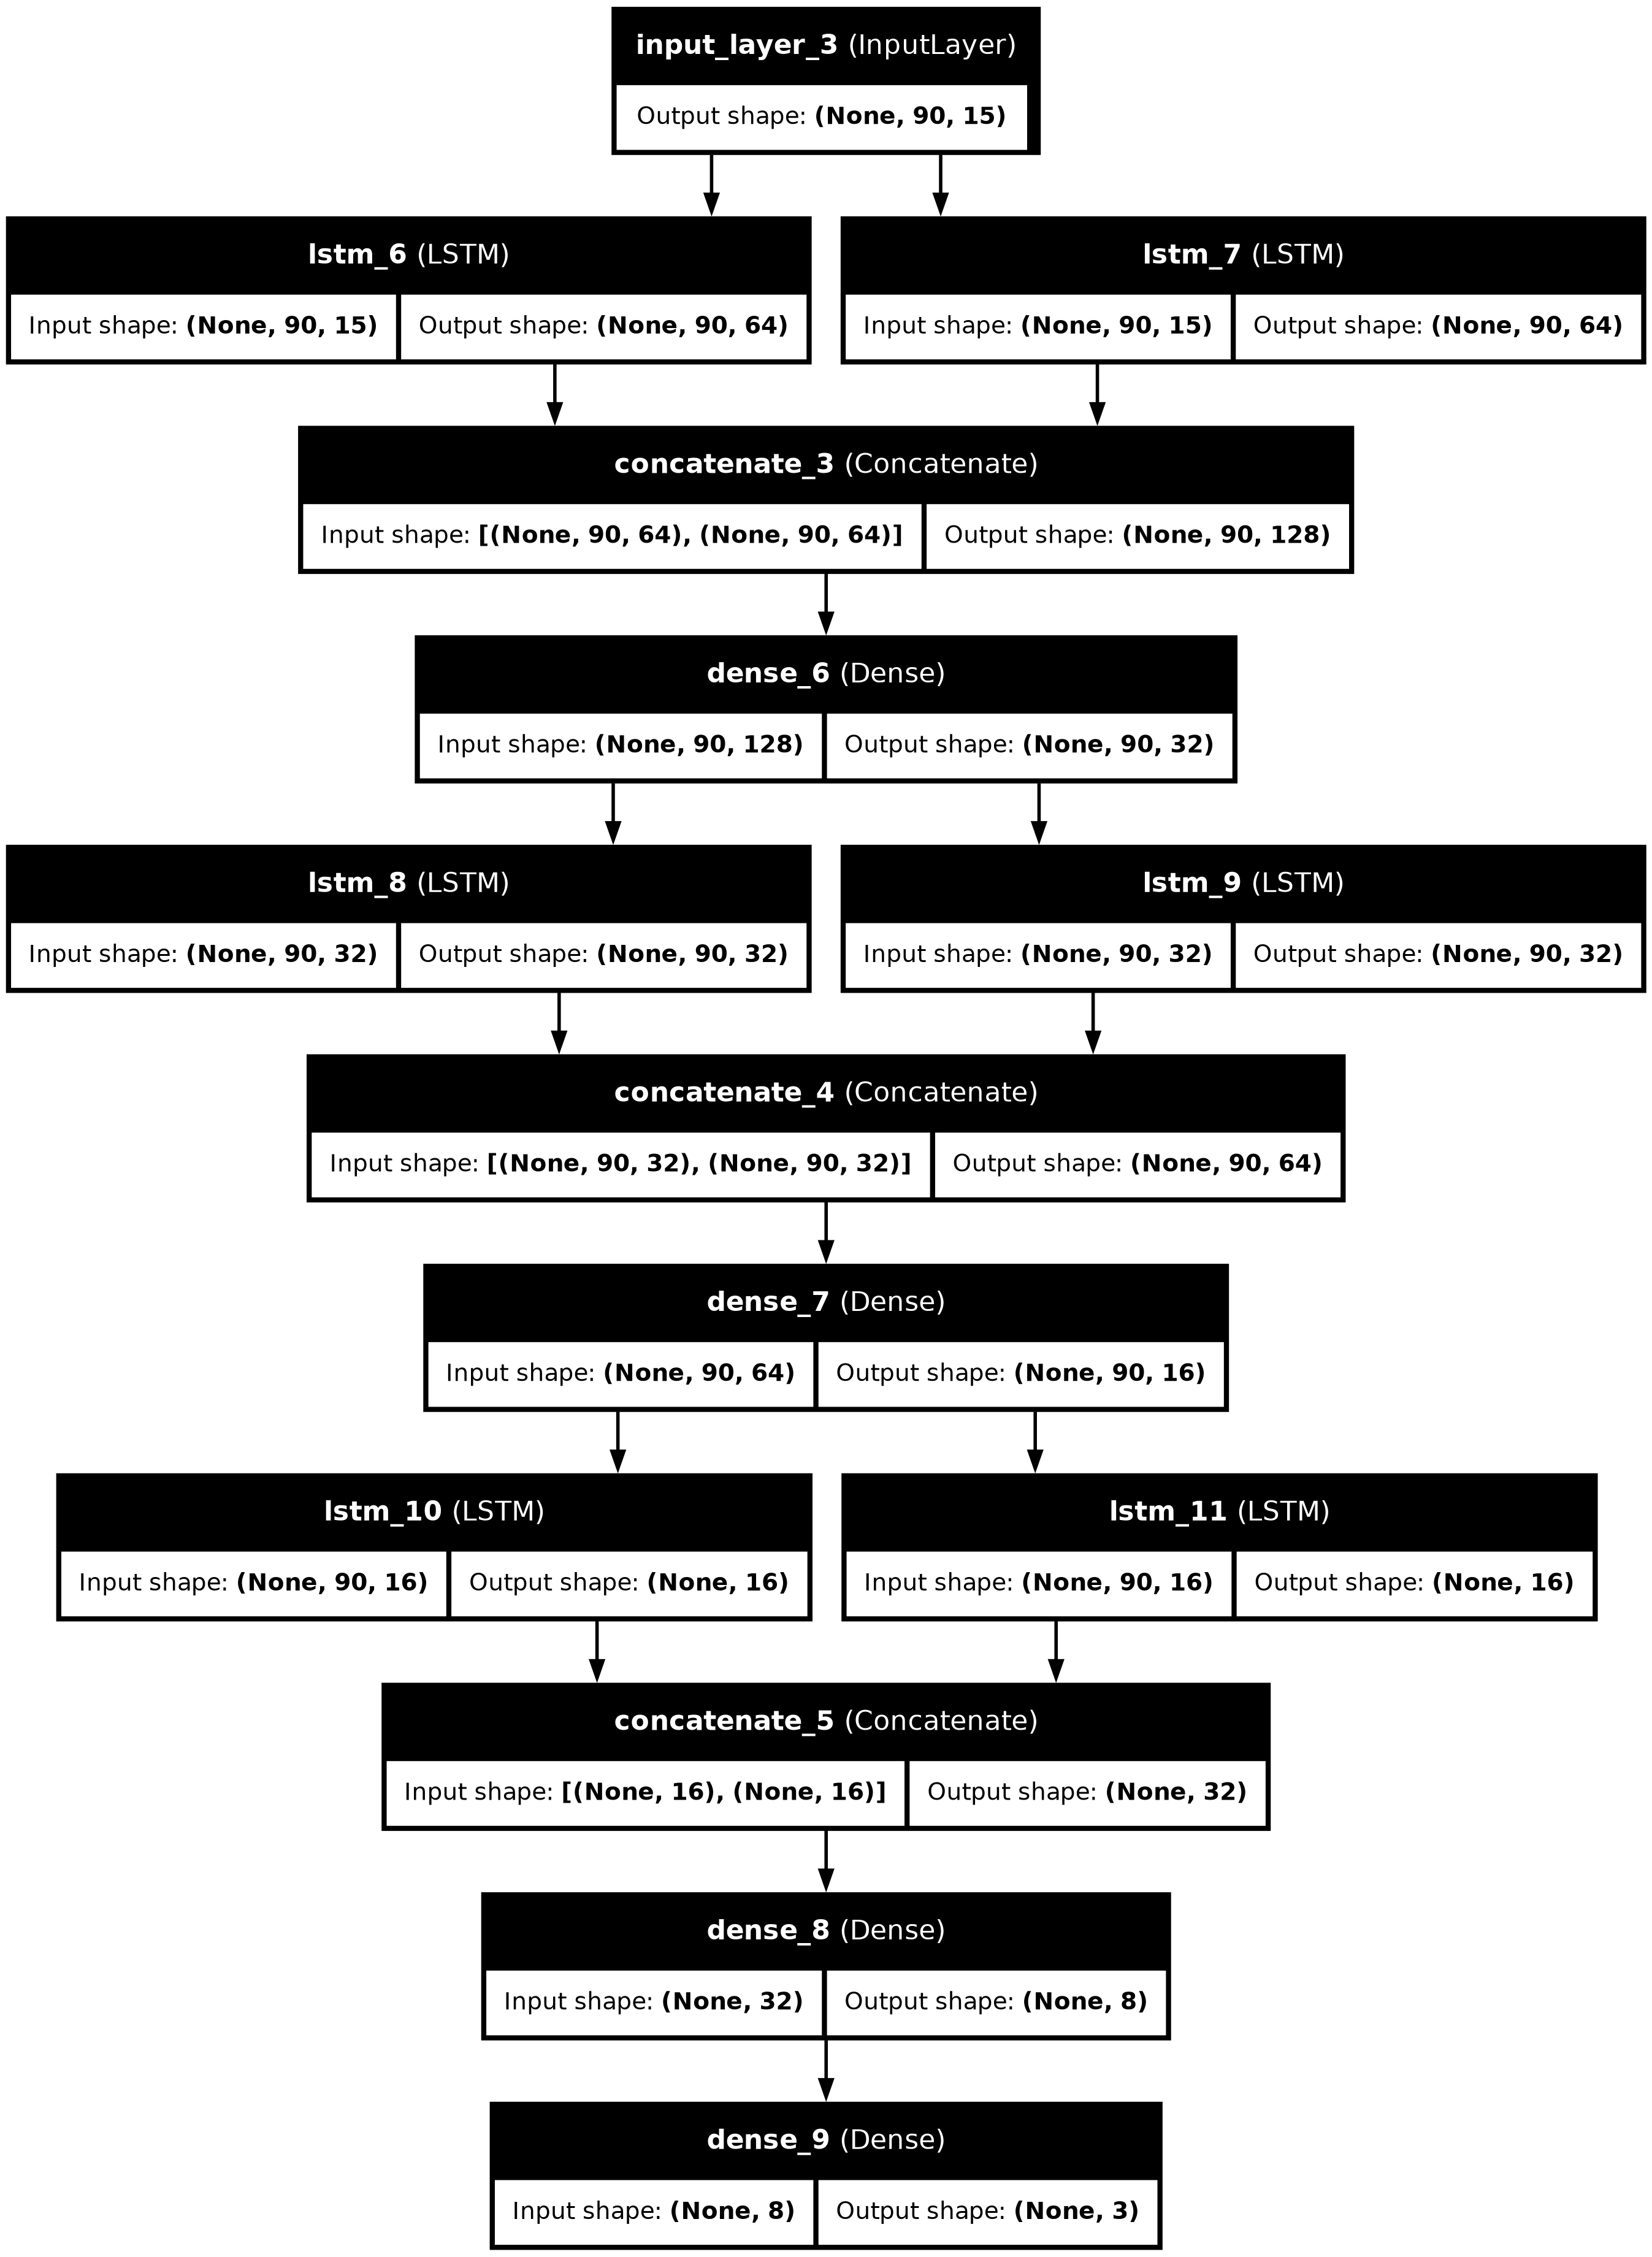

In [93]:
plot_model(model_con, to_file='LSTM_Con_plot.png', show_shapes=True, show_layer_names=True)

In [94]:
model_con.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.MeanAbsoluteError(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.R2Score(),
                            tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_LSTMCon.keras', save_best_only=True, monitor='val_loss')

history_con = model_con.fit(X_train, y_train, 
                              epochs=15, 
                              validation_data=(X_val, y_val), 
                              batch_size=128, 
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint])

model_con.save('model_lstmcon_.keras')

Epoch 1/15
3082/3082 ━━━━━━━━━━━━━━━━━━━━ 123s 37ms/step - loss: 0.0539 - mean_absolute_error: 0.0539 - mean_squared_error: 0.0171 - r2_score: 0.8592 - root_mean_squared_error: 0.1286 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518 - val_mean_squared_error: 0.0141 - val_r2_score: 0.8790 - val_root_mean_squared_error: 0.1188
Epoch 2/15
3082/3082 ━━━━━━━━━━━━━━━━━━━━ 113s 37ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - mean_squared_error: 0.0108 - r2_score: 0.9119 - root_mean_squared_error: 0.1037 - val_loss: 0.0511 - val_mean_absolute_error: 0.0511 - val_mean_squared_error: 0.0139 - val_r2_score: 0.8811 - val_root_mean_squared_error: 0.1178
Epoch 3/15
3082/3082 ━━━━━━━━━━━━━━━━━━━━ 113s 37ms/step - loss: 0.0403 - mean_absolute_error: 0.0403 - mean_squared_error: 0.0102 - r2_score: 0.9162 - root_mean_squared_error: 0.1010 - val_loss: 0.0503 - val_mean_absolute_error: 0.0503 - val_mean_squared_error: 0.0134 - val_r2_score: 0.8854 - val_root_mean_squared_error: 0.1156
Epoch 4

### LSTM with Concat Predictions and Scoring

In [95]:
primary_path = '/kaggle/working/model_LSTMCon.keras'
fallback_path = '/kaggle/input/ccd-result/results/model_LSTMCon.keras'

try:
    model_con = load_model(primary_path)
except:
    model_con = load_model(fallback_path)
    
pred_con = model_con.predict(X_val)
print(pred_con.shape, y_train.shape, y_val.shape)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step
(87720, 3) (394440, 3, 1) (87720, 3, 1)


In [96]:
scaler = scalers['scaler_Total Cloud Cover [%]']
pred_con[:,:]=scaler.inverse_transform(pred_con[:,:])
y_train[:,:,0]=scaler.inverse_transform(y_train[:,:,0])
y_val[:,:,0]=scaler.inverse_transform(y_val[:,:,0])

In [97]:
print("MAE-15: ",mean_absolute_error(y_val[:,0,0],pred_con[:,0]))
print("MAE-25: ",mean_absolute_error(y_val[:,1,0],pred_con[:,1]))
print("MAE-30: ",mean_absolute_error(y_val[:,2,0],pred_con[:,2]))

print("R2-score-15: ", r2_score(y_val[:,0,0],pred_con[:,0]))
print("R2-score-25: ", r2_score(y_val[:,1,0],pred_con[:,1]))
print("R2-score-30: ", r2_score(y_val[:,2,0],pred_con[:,2]))

print("MSE-15: ", mean_squared_error(y_val[:,0,0],pred_con[:,0]))
print("MSE-25: ", mean_squared_error(y_val[:,1,0],pred_con[:,1]))
print("MSE-30: ", mean_squared_error(y_val[:,2,0],pred_con[:,2]))

MAE-15:  3.1535878258131986
MAE-25:  4.110518866308085
MAE-30:  4.5117673262214755
R2-score-15:  0.9290800762409221
R2-score-25:  0.8769648077979137
R2-score-30:  0.8502570392759137
MSE-15:  50.30330575390419
MSE-25:  87.26852150683109
MSE-30:  106.21226784432908


In [98]:
w_mae = mean_absolute_error(y_val[:,0,0],pred_con[:,0]) * .5 + mean_absolute_error(y_val[:,1,0],pred_con[:,1]) * .35 + mean_absolute_error(y_val[:,2,0],pred_con[:,2]) * .15
w_r2 = r2_score(y_val[:,0,0],pred_con[:,0]) * .5 + r2_score(y_val[:,1,0],pred_con[:,1]) * .35 + r2_score(y_val[:,2,0],pred_con[:,2]) * .15
w_mse = (mean_squared_error(y_val[:,0,0],pred_con[:,0]) * 0.5) + (mean_squared_error(y_val[:,1,0],pred_con[:,1]) * 0.35) + (mean_squared_error(y_val[:,2,0],pred_con[:,2]) * 0.15)

print("Weighted MAE: ", w_mae)
print("Weighted R2 Score: ", w_r2)
print("Weighted MSE: ", w_mse)

Weighted MAE:  3.69224061504765
Weighted R2 Score:  0.899016276741118
Weighted MSE:  71.62747558099234


### Training Curve

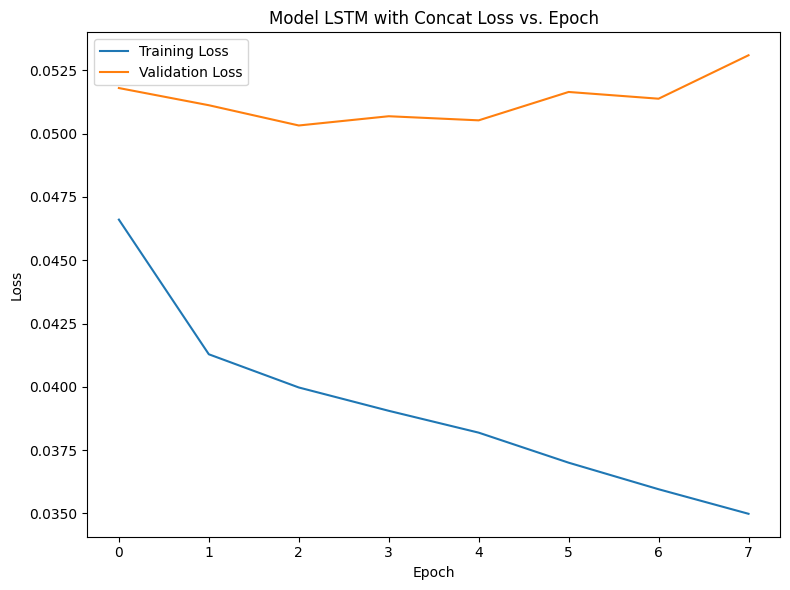

In [99]:
plot_history(history_con, 'Model LSTM with Concat')

## 5) Autoencoder (Seq2Seq Model)

In [ ]:
filename = '/kaggle/working/prepdata.pkl'
X_train, y_train, X_val, y_val = load_dataframes(filename)

In [ ]:
n_past = 90
n_features = 15

model_LSTM_Re = tf.keras.models.Sequential()
# Encoder
model_LSTM_Re.add(tf.keras.layers.LSTM(128, return_state=False, input_shape=(n_past, n_features)))

model_LSTM_Re.add(tf.keras.layers.RepeatVector(len(future_pred)))
# Decoder
model_LSTM_Re.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_LSTM_Re.add(tf.keras.layers.LSTM(64, return_sequences=True))

model_LSTM_Re.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)))
model_LSTM_Re.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64)))
model_LSTM_Re.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32)))
model_LSTM_Re.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

model_LSTM_Re.add(tf.keras.layers.Flatten())


model_LSTM_Re.summary()

In [ ]:
plot_model(model_LSTM_Re, to_file='LSTM_Re_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_LSTM_Re.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.MeanAbsoluteError(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.R2Score(),
                            tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_LSTMRe.keras', save_best_only=True, monitor='val_loss')

history_LSTM_Re = model_LSTM_Re.fit(X_train, y_train, 
                              epochs=15, 
                              validation_data=(X_val, y_val), 
                              batch_size=256, 
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint])

model_LSTM_Re.save('model_lstmre_.keras')

### Autoencoder Predictions and Scoring

In [ ]:
primary_path = '/kaggle/working/model_LSTMRe.keras'
fallback_path = '/kaggle/input/ccd-result/results/model_LSTMRe.keras'

try:
    model_LSTM_Re = load_model(primary_path)
except:
    model_LSTM_Re = load_model(fallback_path)
    
pred_LSTM_Re = model_LSTM_Re.predict(X_val)
print(pred_LSTM_Re.shape, y_train.shape, y_val.shape)

In [ ]:
scaler = scalers['scaler_Total Cloud Cover [%]']
pred_LSTM_Re[:,:]=scaler.inverse_transform(pred_LSTM_Re[:,:])
y_train[:,:,0]=scaler.inverse_transform(y_train[:,:,0])
y_val[:,:,0]=scaler.inverse_transform(y_val[:,:,0])

In [ ]:
print("MAE-15: ",mean_absolute_error(y_val[:,0,0],pred_LSTM_Re[:,0]))
print("MAE-25: ",mean_absolute_error(y_val[:,1,0],pred_LSTM_Re[:,1]))
print("MAE-30: ",mean_absolute_error(y_val[:,2,0],pred_LSTM_Re[:,2]))

print("R2-score-15: ", r2_score(y_val[:,0,0],pred_LSTM_Re[:,0]))
print("R2-score-25: ", r2_score(y_val[:,1,0],pred_LSTM_Re[:,1]))
print("R2-score-30: ", r2_score(y_val[:,2,0],pred_LSTM_Re[:,2]))

print("MSE-15: ", mean_squared_error(y_val[:,0,0],pred_LSTM_Re[:,0]))
print("MSE-25: ", mean_squared_error(y_val[:,1,0],pred_LSTM_Re[:,1]))
print("MSE-30: ", mean_squared_error(y_val[:,2,0],pred_LSTM_Re[:,2]))

In [ ]:
w_mae = mean_absolute_error(y_val[:,0,0],pred_LSTM_Re[:,0]) * .5 + mean_absolute_error(y_val[:,1,0],pred_LSTM_Re[:,1]) * .35 + mean_absolute_error(y_val[:,2,0],pred_LSTM_Re[:,2]) * .15
w_r2 = r2_score(y_val[:,0,0],pred_LSTM_Re[:,0]) * .5 + r2_score(y_val[:,1,0],pred_LSTM_Re[:,1]) * .35 + r2_score(y_val[:,2,0],pred_LSTM_Re[:,2]) * .15
w_mse = (mean_squared_error(y_val[:,0,0],pred_LSTM_Re[:,0]) * 0.5) + (mean_squared_error(y_val[:,1,0],pred_LSTM_Re[:,1]) * 0.35) + (mean_squared_error(y_val[:,2,0],pred_LSTM_Re[:,2]) * 0.15)

print("Weighted MAE: ", w_mae)
print("Weighted R2 Score: ", w_r2)
print("Weighted MSE: ", w_mse)

### Training Curve

In [ ]:
plot_history(history_LSTM_Re, 'Model Autoencoder')

## 6) Custom Transformer

In [ ]:
filename = '/kaggle/working/prepdata.pkl'
X_train, y_train, X_val, y_val = load_dataframes(filename)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, lstm_units, dropout=0):
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True))(x)

    x = layers.Conv1D(filters=ff_dim * 2, kernel_size=1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=n_features, kernel_size=1)(x)
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    lstm_units,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, lstm_units, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(3)(x) 
    return keras.Model(inputs, outputs)

n_past = 90
n_features = 15
input_shape = (n_past, n_features)

model_transformer = build_model(
    input_shape,
    head_size=32,
    num_heads=4,
    ff_dim=4,
    lstm_units=16,
    num_transformer_blocks=3,
    mlp_units=[32],
    mlp_dropout=0.2,
    dropout=0.2,
)

model_transformer.summary()

In [ ]:
# To convert the above code to functional so we can plot functional blocks better.
plot_model(model_transformer, to_file='transformer_plot.png', show_shapes=True, show_layer_names=True, expand_nested=False)

In [ ]:
model_transformer.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.MeanAbsoluteError(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.R2Score(),
                            tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_transformer.keras', save_best_only=True, monitor='val_loss')

history_transformer = model_transformer.fit(X_train, y_train, 
                              epochs=15, 
                              validation_data=(X_val, y_val), 
                              batch_size=32, 
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint])


model_transformer.save('model_transformer_.keras')

### Transformer Predictions and Scoring

In [ ]:
primary_path = '/kaggle/working/model_transformer.keras'
fallback_path = '/kaggle/input/ccd-result/results/model_transformer.keras'

try:
    model_transformer = load_model(primary_path)
except:
    model_transformer = load_model(fallback_path)
    
pred_transformer = model_transformer.predict(X_val)
print(pred_transformer.shape, y_train.shape, y_val.shape)

In [ ]:
scaler = scalers['scaler_Total Cloud Cover [%]']
pred_transformer[:,:]=scaler.inverse_transform(pred_transformer[:,:])
y_train[:,:,0]=scaler.inverse_transform(y_train[:,:,0])
y_val[:,:,0]=scaler.inverse_transform(y_val[:,:,0])

In [ ]:
print("MAE-15: ",mean_absolute_error(y_val[:,0,0],pred_transformer[:,0]))
print("MAE-25: ",mean_absolute_error(y_val[:,1,0],pred_transformer[:,1]))
print("MAE-30: ",mean_absolute_error(y_val[:,2,0],pred_transformer[:,2]))

print("R2-score-15: ", r2_score(y_val[:,0,0],pred_transformer[:,0]))
print("R2-score-25: ", r2_score(y_val[:,1,0],pred_transformer[:,1]))
print("R2-score-30: ", r2_score(y_val[:,2,0],pred_transformer[:,2]))

print("MSE-15: ", mean_squared_error(y_val[:,0,0],pred_transformer[:,0]))
print("MSE-25: ", mean_squared_error(y_val[:,1,0],pred_transformer[:,1]))
print("MSE-30: ", mean_squared_error(y_val[:,2,0],pred_transformer[:,2]))

In [ ]:
w_mae = mean_absolute_error(y_val[:,0,0],pred_transformer[:,0]) * .5 + mean_absolute_error(y_val[:,1,0],pred_transformer[:,1]) * .35 + mean_absolute_error(y_val[:,2,0],pred_transformer[:,2]) * .15
w_r2 = r2_score(y_val[:,0,0],pred_transformer[:,0]) * .5 + r2_score(y_val[:,1,0],pred_transformer[:,1]) * .35 + r2_score(y_val[:,2,0],pred_transformer[:,2]) * .15
w_mse = (mean_squared_error(y_val[:,0,0],pred_transformer[:,0]) * 0.5) + (mean_squared_error(y_val[:,1,0],pred_transformer[:,1]) * 0.35) + (mean_squared_error(y_val[:,2,0],pred_transformer[:,2]) * 0.15)

print("Weighted MAE: ", w_mae)
print("Weighted R2 Score: ", w_r2)
print("Weighted MSE: ", w_mse)

### Training Curve

In [ ]:
plot_history(history_transformer, 'Model Custom Transformer')

## 7) Conv1D + LSTM

In [ ]:
filename = '/kaggle/working/prepdata.pkl'
X_train, y_train, X_val, y_val = load_dataframes(filename)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense

n_past = 90
n_features = 15

model_lstm_cnn = Sequential([
    Conv1D(128, kernel_size=6, activation='relu', input_shape=(n_past, n_features)),
    MaxPooling1D(2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(32, kernel_size=1, activation='relu'),
    MaxPooling1D(2),
    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    GRU(64, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    #Dense(64, activation='relu'),
    Dense(3)
], name="model_lstm_cnn")

model_lstm_cnn.summary()

In [ ]:
plot_model(model_lstm_cnn, to_file='lstm_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_lstm_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.MeanAbsoluteError(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.R2Score(),
                            tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_lstm_cnn.keras', save_best_only=True, monitor='val_loss')

history_lstm_cnn = model_lstm_cnn.fit(X_train, y_train, 
                              epochs=15, 
                              validation_data=(X_val, y_val), 
                              batch_size=32, 
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint])


model_transformer.save('model_lstm_cnn_.keras')

### Conv1D + LSTM Predictions and Scoring

In [ ]:
primary_path = '/kaggle/working/model_lstm_cnn.keras'
fallback_path = '/kaggle/input/ccd-result/results/model_lstm_cnn.keras'

try:
    model_lstm_cnn = load_model(primary_path)
except:
    model_lstm_cnn = load_model(fallback_path)
    
pred_lstm_cnn = model_lstm_cnn.predict(X_val)
print(pred_lstm_cnn.shape, y_train.shape, y_val.shape)

In [ ]:
scaler = scalers['scaler_Total Cloud Cover [%]']
pred_lstm_cnn[:,:]=scaler.inverse_transform(pred_lstm_cnn[:,:])
y_train[:,:,0]=scaler.inverse_transform(y_train[:,:,0])
y_val[:,:,0]=scaler.inverse_transform(y_val[:,:,0])

In [ ]:
print("MAE-15: ",mean_absolute_error(y_val[:,0,0],pred_lstm_cnn[:,0]))
print("MAE-25: ",mean_absolute_error(y_val[:,1,0],pred_lstm_cnn[:,1]))
print("MAE-30: ",mean_absolute_error(y_val[:,2,0],pred_lstm_cnn[:,2]))

print("R2-score-15: ", r2_score(y_val[:,0,0],pred_lstm_cnn[:,0]))
print("R2-score-25: ", r2_score(y_val[:,1,0],pred_lstm_cnn[:,1]))
print("R2-score-30: ", r2_score(y_val[:,2,0],pred_lstm_cnn[:,2]))

print("MSE-15: ", mean_squared_error(y_val[:,0,0],pred_lstm_cnn[:,0]))
print("MSE-25: ", mean_squared_error(y_val[:,1,0],pred_lstm_cnn[:,1]))
print("MSE-30: ", mean_squared_error(y_val[:,2,0],pred_lstm_cnn[:,2]))

In [ ]:
w_mae = mean_absolute_error(y_val[:,0,0],pred_lstm_cnn[:,0]) * .5 + mean_absolute_error(y_val[:,1,0],pred_lstm_cnn[:,1]) * .35 + mean_absolute_error(y_val[:,2,0],pred_lstm_cnn[:,2]) * .15
w_r2 = r2_score(y_val[:,0,0],pred_lstm_cnn[:,0]) * .5 + r2_score(y_val[:,1,0],pred_lstm_cnn[:,1]) * .35 + r2_score(y_val[:,2,0],pred_lstm_cnn[:,2]) * .15
w_mse = (mean_squared_error(y_val[:,0,0],pred_lstm_cnn[:,0]) * 0.5) + (mean_squared_error(y_val[:,1,0],pred_lstm_cnn[:,1]) * 0.35) + (mean_squared_error(y_val[:,2,0],pred_lstm_cnn[:,2]) * 0.15)

print("Weighted MAE: ", w_mae)
print("Weighted R2 Score: ", w_r2)
print("Weighted MSE: ", w_mse)

### Training Curve

In [ ]:
plot_history(history_lstm_cnn, 'Model Conv1D + BiLSTM')

# Testing

## Final Results

In [264]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [265]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
import pickle

# Load pre-trained Keras models
model1 = load_model('/kaggle/input/ccd-weights/modelweights/model_rnn_final.keras')
model2 = load_model('/kaggle/input/ccd-weights/modelweights/model_gru.keras')
model3 = load_model('/kaggle/input/ccd-weights/modelweights/model_lstm.keras')
model4 = load_model('/kaggle/input/ccd-weights/modelweights/model_LSTMCon.keras')
model5 = load_model('/kaggle/input/ccd-weights/modelweights/model_LSTMRe.keras')
model6 = load_model('/kaggle/input/ccd-weights/modelweights/model_transformer.keras')
model7 = load_model('/kaggle/input/ccd-weights/modelweights/model_lstm_cnn.keras')


# newmodel1 = load_model('')
# newmodel2 = load_model('')
# newmodel3 = load_model('')
# newmodel4 = load_model('')
# newmodel5 = load_model('') 


In [266]:
# Load data
filename = '/kaggle/working/prepdata.pkl'
X_train, y_train, X_val, y_val = load_dataframes(filename)

In [267]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(394440, 90, 15) (394440, 3, 1) (87720, 90, 15) (87720, 3, 1)


In [268]:
# num_samples_train, num_timesteps_train, num_features_train = X_train.shape
# X_train_flat = X_train.reshape(num_samples_train, -1)

# num_samples_val, num_timesteps_val, num_features_val = X_val.shape
# X_val_flat = X_val.reshape(num_samples_val, -1)

# num_samples_train, num_timesteps_train, num_features_train = y_train.shape
# y_train_flat = y_train.reshape(num_samples_train, -1)

# num_samples_val, num_timesteps_val, num_features_val = y_val.shape
# y_val_flat = y_val.reshape(num_samples_val, -1)

In [269]:
# print(X_train_flat.shape, X_val_flat.shape ,y_train_flat.shape, y_val_flat.shape)

In [270]:
# model1pred = model1.predict(X_train)
model1valpred = model1.predict(X_val)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step


In [271]:
# model2pred = model2.predict(X_train)
model2valpred = model2.predict(X_val)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


In [272]:
# model3pred = model3.predict(X_train)
model3valpred = model3.predict(X_val)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step


In [273]:
# model4pred = model4.predict(X_train)
model4valpred = model4.predict(X_val)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step


In [274]:
# model5pred = model5.predict(X_train)
model5valpred = model5.predict(X_val)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


In [275]:
# model6pred = model6.predict(X_train)
model6valpred = model6.predict(X_val)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


In [276]:
# model7pred = model7.predict(X_train)
model7valpred = model7.predict(X_val)

2742/2742 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [277]:
model1valpred.shape

(87720, 3)

In [280]:
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1])

In [281]:
y_val

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [279]:
model1valpred

array([[ 0.00186092, -0.00029859, -0.0004101 ],
       [ 0.00186092, -0.00029859, -0.0004101 ],
       [ 0.00186092, -0.00029859, -0.0004101 ],
       ...,
       [ 0.00186092, -0.00029859, -0.0004101 ],
       [ 0.00186092, -0.00029859, -0.0004101 ],
       [ 0.00186092, -0.00029859, -0.0004101 ]], dtype=float32)

In [282]:
allmodels = [model1valpred, model2valpred, model3valpred, model4valpred, model5valpred, model6valpred, model7valpred]
j = 1
for i in allmodels:
    mse = mean_squared_error(y_val, i)
    mae = mean_absolute_error(y_val, i)
    r2 = r2_score(y_val, i)
    print(f'{j} R2 Score: {r2}')
    j += 1

1 R2 Score: 0.8840937160754202
2 R2 Score: 0.8908423644267365
3 R2 Score: 0.8915048856756859
4 R2 Score: 0.8854339747287678
5 R2 Score: 0.8899584569514172
6 R2 Score: 0.8725913575317606
7 R2 Score: 0.8720750012813715


In [ ]:
import numpy as np

all_predictions = np.stack([model4valpred, model5valpred, model7valpred, model8valpred], axis=-1)
new_predictions = np.stack([model4valpred, model5valpred, model7valpred, model8valpred, newmodel1valpred, newmodel3valpred], axis=-1)

print(all_predictions.shape, new_predictions.shape)

In [ ]:
average_predictions = np.mean(all_predictions, axis=-1, keepdims=True)
new_predictions = np.mean(new_predictions, axis=-1, keepdims=True)

In [ ]:
average_predictions = average_predictions.reshape(87720, 3)
new_predictions = new_predictions.reshape(87720, 3)

In [ ]:
y_val = y_val.reshape(87720, 3)

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_val, average_predictions)
mae = mean_absolute_error(y_val, average_predictions)
r2 = r2_score(y_val, average_predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_val, new_predictions)
mae = mean_absolute_error(y_val, new_predictions)
r2 = r2_score(y_val, new_predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

## Final Test Set Predictions

In [349]:
model1testpred = model1.predict(X_test)
model2testpred = model2.predict(X_test)
model3testpred = model3.predict(X_test)
model4testpred = model4.predict(X_test)
model5testpred = model5.predict(X_test)
model6testpred = model6.predict(X_test)
model7testpred = model7.predict(X_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [350]:
print(model1testpred.shape, model2testpred.shape, model3testpred.shape, model4testpred.shape, model5testpred.shape, model6testpred.shape, model7testpred.shape)

(155, 3) (155, 3) (155, 3) (155, 3) (155, 3) (155, 3) (155, 3)


In [351]:
test_predictions = np.stack([model1testpred, model2testpred, model3testpred, model4testpred, model5testpred, model6testpred, model7testpred], axis=-1) #model1testpred, model2testpred, model3testpred, model4testpred, model5testpred, model6testpred, model7testpred
test_predictions = np.mean(test_predictions, axis=-1, keepdims=True)
test_predictions = test_predictions.reshape(155, 3)
scaler = scalers['scaler_Total Cloud Cover [%]']
test_predictions[:,:]=scaler.inverse_transform(test_predictions[:,:])

In [362]:
test_predictions_reshaped = test_predictions.reshape((155, 3))
scenario_set = np.arange(155).reshape((155, 1))
output_array = np.concatenate((scenario_set, test_predictions_reshaped), axis=1)
print(output_array.shape) 

(155, 4)


In [360]:
test_predictions.shape

(155, 3)

In [363]:
output_array

array([[  0.        ,  23.76028061,  24.09092712,  24.15224838],
       [  1.        ,  21.75287247,  21.23754311,  20.93353271],
       [  2.        ,  30.29822922,  30.56130028,  30.40251732],
       [  3.        ,  19.12137604,  21.0092392 ,  21.10671997],
       [  4.        ,  13.25512981,  13.35740852,  13.28910255],
       [  5.        ,  97.10021973,  96.87050629,  96.53347778],
       [  6.        ,  96.90969849,  96.69210052,  96.33473969],
       [  7.        ,  96.81352997,  96.51164246,  96.0887146 ],
       [  8.        ,  96.73666382,  96.39823914,  95.94204712],
       [  9.        ,  96.13250732,  95.64961243,  95.06491089],
       [ 10.        ,  95.36455536,  94.71406555,  94.01834869],
       [ 11.        ,  96.23907471,  95.57723999,  94.89916229],
       [ 12.        ,  93.23712921,  92.4727478 ,  91.68850708],
       [ 13.        ,  94.64072418,  93.99819946,  93.26322937],
       [ 14.        ,  91.15818787,  90.0923996 ,  89.12984467],
       [ 15.        ,  94

In [365]:
y_test = pd.read_csv("/kaggle/input/ccdfinal/CCD_Y.csv")

In [355]:
y_test = y_test.iloc[:, 1:]

In [356]:
y_test

,15,25,30
0,23.0,24.0,15.0
1,19.0,17.0,12.0
2,28.0,9.0,18.0
3,7.0,14.0,9.0
4,13.0,13.0,17.0
...,...,...,...
150,64.0,76.0,69.0
151,75.0,77.0,42.0
152,81.0,54.0,24.0
153,67.0,28.0,21.0


In [367]:
allmodels = [output_array]
j = 1
for i in allmodels:
    mse = mean_squared_error(y_test, i)
    mae = mean_absolute_error(y_test, i)
    r2 = r2_score(y_test, i)
    print(f'{j} R2 Score: {r2}')
    j += 1

1 R2 Score: 0.9308043942773394


In [369]:
df = pd.DataFrame(output_array[:, :], columns=['scenario_set', '15', '25', '30'])
df['scenario_set'] = df['scenario_set'].astype(int)
df.to_csv('subover.csv', index=False)

In [370]:
output_array

array([[  0.        ,  23.76028061,  24.09092712,  24.15224838],
       [  1.        ,  21.75287247,  21.23754311,  20.93353271],
       [  2.        ,  30.29822922,  30.56130028,  30.40251732],
       [  3.        ,  19.12137604,  21.0092392 ,  21.10671997],
       [  4.        ,  13.25512981,  13.35740852,  13.28910255],
       [  5.        ,  97.10021973,  96.87050629,  96.53347778],
       [  6.        ,  96.90969849,  96.69210052,  96.33473969],
       [  7.        ,  96.81352997,  96.51164246,  96.0887146 ],
       [  8.        ,  96.73666382,  96.39823914,  95.94204712],
       [  9.        ,  96.13250732,  95.64961243,  95.06491089],
       [ 10.        ,  95.36455536,  94.71406555,  94.01834869],
       [ 11.        ,  96.23907471,  95.57723999,  94.89916229],
       [ 12.        ,  93.23712921,  92.4727478 ,  91.68850708],
       [ 13.        ,  94.64072418,  93.99819946,  93.26322937],
       [ 14.        ,  91.15818787,  90.0923996 ,  89.12984467],
       [ 15.        ,  94